In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
from dataset import get_dataloader
from model import get_model
from criterion import get_criterion
from metric import get_metric
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch
from torchvision import models
import yaml
import json
from utils import visualize_2d, heatmaps_to_coordinates, visualize_3d
from PIL import Image, ImageFilter
from scipy.io import loadmat
import cv2
import pandas as pd

In [26]:
keypoint_error = get_metric('keypoint_error')

In [27]:
batch_avg_keypoint_error_2d = keypoint_error(sample, output, 'vector_2d', True)
error_keypoint_2d = batch_avg_keypoint_error_2d['keypoint_error']
present_counter = batch_avg_keypoint_error_2d['present_counter']
print(error_keypoint_2d)
print(present_counter)

[  0.         373.89692402 355.90765738 345.00034976 352.35349143
 155.83989048 174.68317813 302.31872737 418.98861361 109.48929131
 191.77935445 358.496216   430.92931628 123.59136832 190.20485306
 213.14990854 239.48541188 193.80455768 251.20868373 326.71555138
 250.76645947]
[ 0. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16.]


In [28]:
error_keypoint_2d / 16

array([ 0.        , 23.36855775, 22.24422859, 21.56252186, 22.02209321,
        9.73999316, 10.91769863, 18.89492046, 26.18678835,  6.84308071,
       11.98620965, 22.4060135 , 26.93308227,  7.72446052, 11.88780332,
       13.32186928, 14.96783824, 12.11278486, 15.70054273, 20.41972196,
       15.67290372])

In [3]:
experiment = 'e023'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 16
cuda = int(config['cuda'])
#config['dataset'] = 'dexter+object'
dataloader = get_dataloader(config, 'val')
model = get_model(config)
model.load_state_dict(torch.load('experiment/' + experiment + '/' + config['weights'])['model'])

Images in Stereo dataset: 3000. Augmentation: False


In [4]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)
sample['image'] = sample['image'].cpu()

/home/ochernytska/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


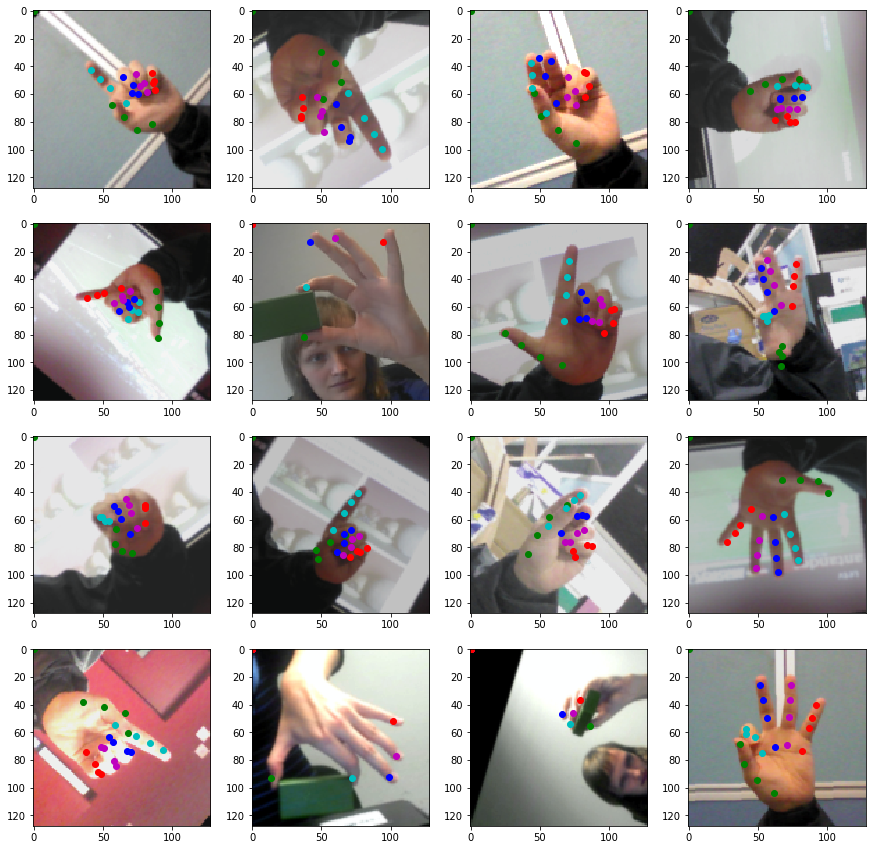

In [98]:
plt.figure(figsize=[15,15])
for i in range(16):
    plt.subplot(4,4,i+1)
    img = sample['image'][i,:,:,:]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    keypoints = sample['vector_2d'][i].numpy()
    keypoints = np.reshape(keypoints,(21,2)) * 128
    #plt.plot(keypoints[1:5,0], keypoints[1:5,1], 'g') 
    plt.plot(keypoints[:5,0], keypoints[:5,1], 'go')
    #plt.plot(keypoints[[5,6,7,8],0], keypoints[[5,6,7,8],1], 'c') 
    plt.plot(keypoints[5:9,0], keypoints[5:9,1], 'co')
    #plt.plot(keypoints[[9,10,11,12],0], keypoints[[9,10,11,12],1], 'b') 
    plt.plot(keypoints[9:13,0], keypoints[9:13,1], 'bo')
    #plt.plot(keypoints[[13,14,15,16],0], keypoints[[13,14,15,16],1], 'm') 
    plt.plot(keypoints[13:17,0], keypoints[13:17,1], 'mo')
    #plt.plot(keypoints[[17,18,19,20],0], keypoints[[17,18,19,20],1], 'r') 
    plt.plot(keypoints[17:21,0], keypoints[17:21,1], 'ro')
    #plt.title(sample['name'][i])
plt.show()

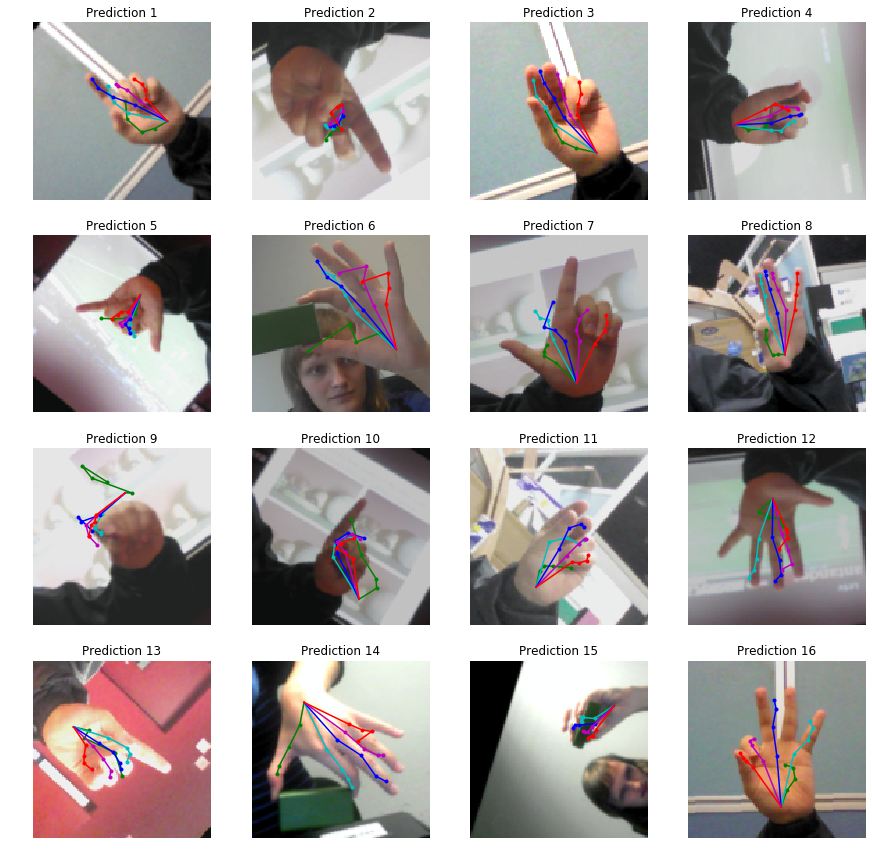

In [99]:
vector = output['vector_2d'].detach().cpu()
sample['image'] = sample['image'].cpu()
visualize_2d(sample['image'], vector)

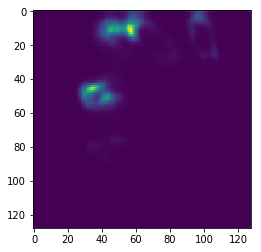

In [112]:
plt.imshow(prod[5,8,:,:].detach().cpu().numpy())

In [30]:
output['heatmaps'].shape

torch.Size([16, 21, 128, 128])

In [101]:
x = sample['is_present'].unsqueeze(2).unsqueeze(2).repeat([1,1,128,128]).cuda(cuda)
x.shape

torch.Size([16, 21, 128, 128])

In [102]:
sample['is_present'][1]

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

In [120]:
x = torch.zeros_like(sample['heatmaps'])
y = torch.ones_like(sample['heatmaps'])
x.shape

torch.Size([16, 21, 128, 128])

In [121]:
loss(x,y)

tensor(1.)

In [116]:
loss(prod, sample['heatmaps'].cuda(cuda))

tensor(0.6973, device='cuda:1', grad_fn=<AddBackward>)

In [59]:
torch.mul(output['heatmaps'], sample['is_present'])

RuntimeError: The size of tensor a (128) must match the size of tensor b (21) at non-singleton dimension 3

In [95]:
[2,2,4] * 1.0

TypeError: can't multiply sequence by non-int of type 'float'

In [20]:
def _loss(self, sample, output):
    loss = 0
    return_dict = {}
        
    for i, l_name in enumerate(self.loss_dict['output_name']):
        sample_name = self.loss_dict['sample_name'][i]
        
        if l_name == 'heatmaps':
            img_size = sample['heatmaps'].shape[2]
            pres = sample['is_present'].unsqueeze(2).unsqueeze(2)
            pres = pres.repeat([1,1,img_size,img_size]).cuda(cuda)
            output = torch.mul(output[l_name],pres) 
            
            nter_loss = self.loss_dict['loss'][i] (output, 
                                                sample[sample_name].cuda(self.cuda))
        else:
            inter_loss = self.loss_dict['loss'][i] (output[l_name], 
                                                sample[sample_name].cuda(self.cuda)) 
        return_dict[l_name] = inter_loss
        loss += inter_loss * self.loss_dict['weight'][i]       
        
    return_dict['total'] = loss
    return return_dict
    

In [37]:
loss = get_criterion('iou')

In [38]:
loss(output['heatmaps'], sample['heatmaps'].cuda(cuda))

tensor(0.7291, device='cuda:1', grad_fn=<AddBackward>)

In [ ]:
output['heatmaps']

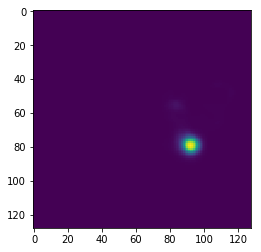

In [55]:
plt.imshow(output['heatmaps'][3,20,:,:].detach().cpu().numpy())

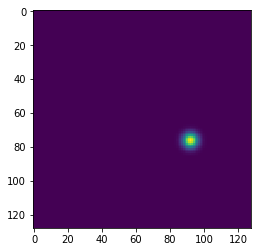

In [54]:
plt.imshow(sample['heatmaps'][3,20,:,:].detach().cpu().numpy())

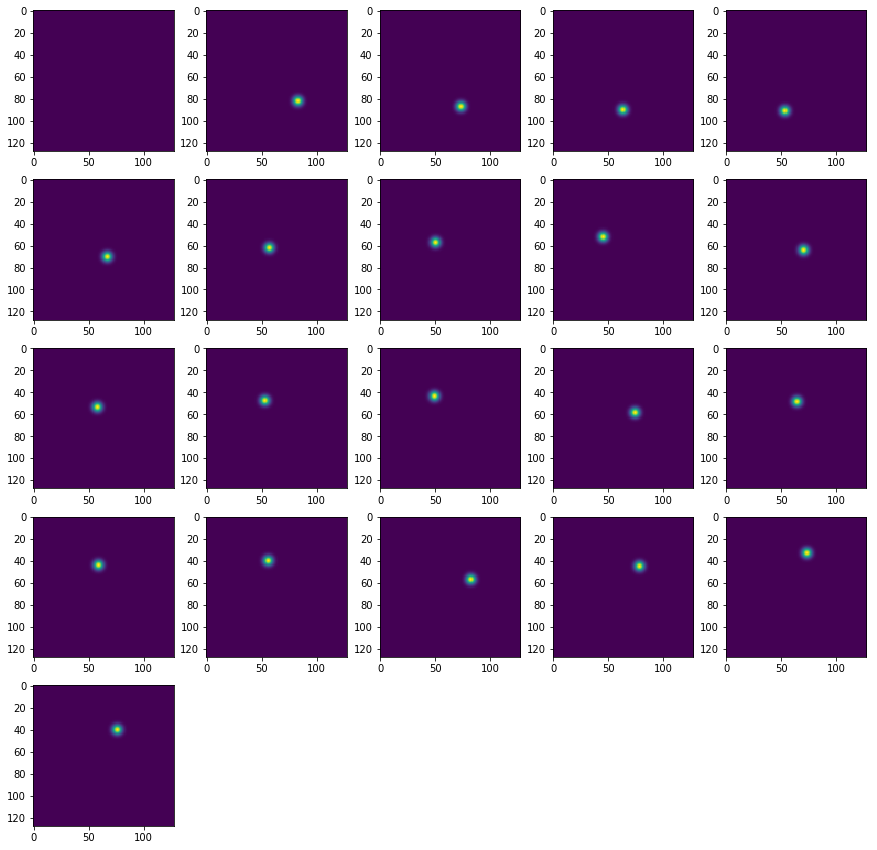

In [15]:
plt.figure(figsize=[15,15])
for i in range(21):
    plt.subplot(5,5,i+1)
    plt.imshow(sample['heatmaps'][0,i,:,:])
    
plt.show()

In [10]:
experiment = 'e020'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 8
cuda = int(config['cuda'])
config['dataset'] = 'stereo'
dataloader = get_dataloader(config, 'train')
model = get_model(config)
model.load_state_dict(torch.load('experiment/' + experiment + '/' + config['weights'])['model'])

Images in Stereo dataset: 15000


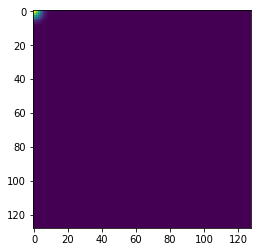

In [16]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)


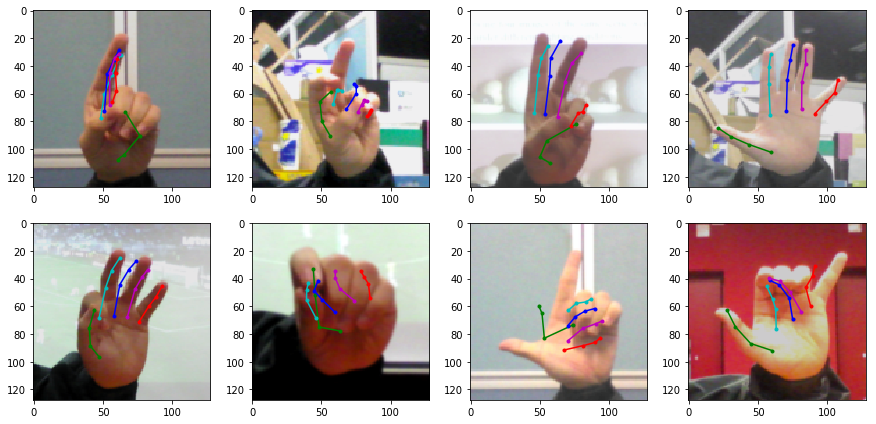

In [17]:
plt.figure(figsize=[15,15])
#sample = next(iter(dataloader))
sample['image'] = sample['image'].cpu()
for i in range(8):
    plt.subplot(4,4,i+1)
    
    img = sample['image'][i,:,:,:]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    keypoints = output['vector_2d'][i].detach().cpu().numpy()
    keypoints = np.reshape(keypoints,(21,2)) * 128
    plt.plot(keypoints[1:5,0], keypoints[1:5,1], 'g') 
    plt.plot(keypoints[1:5,0], keypoints[1:5,1], 'go', ms=3)
    plt.plot(keypoints[[5,6,7,8],0], keypoints[[5,6,7,8],1], 'c') 
    plt.plot(keypoints[5:9,0], keypoints[5:9,1], 'co', ms=3)
    plt.plot(keypoints[[9,10,11,12],0], keypoints[[9,10,11,12],1], 'b') 
    plt.plot(keypoints[9:13,0], keypoints[9:13,1], 'bo', ms=3)
    plt.plot(keypoints[[13,14,15,16],0], keypoints[[13,14,15,16],1], 'm') 
    plt.plot(keypoints[13:17,0], keypoints[13:17,1], 'mo', ms=3)
    plt.plot(keypoints[[17,18,19,20],0], keypoints[[17,18,19,20],1], 'r') 
    plt.plot(keypoints[17:21,0], keypoints[17:21,1], 'ro', ms=3)
    #plt.title(sample['name'][i])
plt.show()

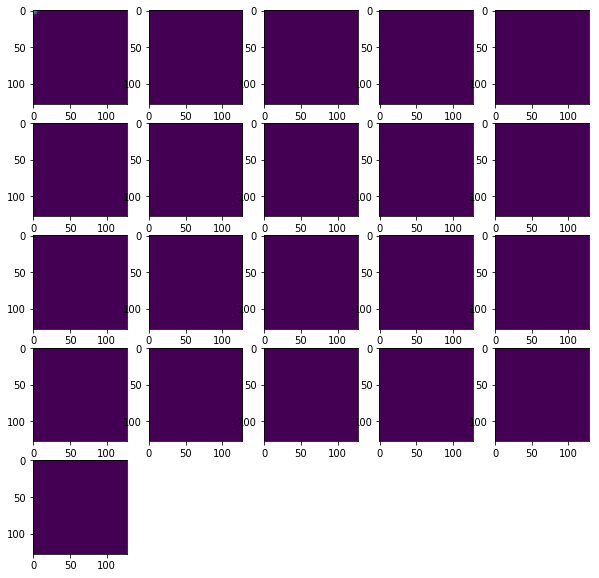

In [19]:
heatmaps = sample['heatmaps'].numpy()
index = 2
plt.figure(figsize=[10,10])
for i in range(21):
    heatmap = heatmaps[index,i,:,:]
    plt.subplot(5,5,i+1)
    plt.imshow(heatmap)
    
plt.show()

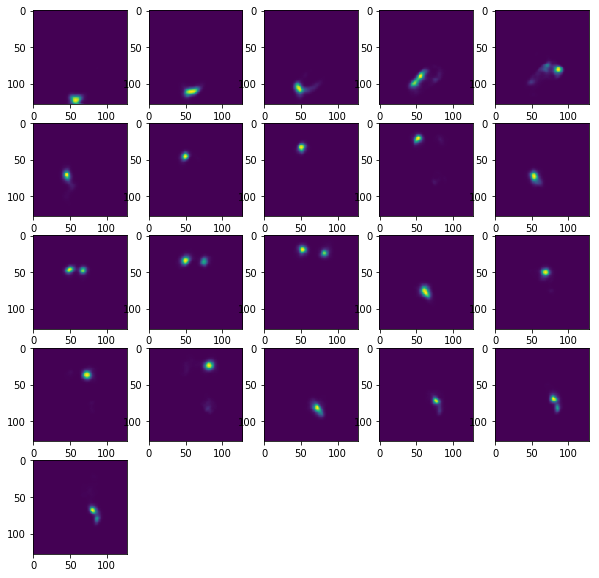

In [18]:
heatmaps = output['heatmaps'].detach().cpu().numpy()
index = 2
plt.figure(figsize=[10,10])
for i in range(21):
    heatmap = heatmaps[index,i,:,:]
    plt.subplot(5,5,i+1)
    plt.imshow(heatmap)
    
plt.show()

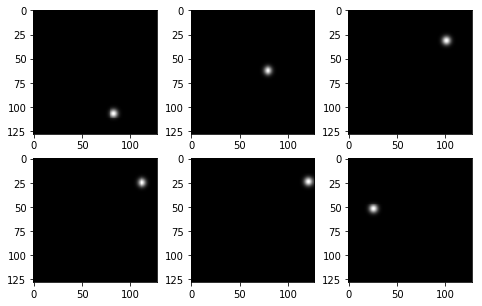

In [21]:
heatmaps = sample['heatmaps'].detach().cpu().numpy()
plt.figure(figsize=[8,5])
for i in range(6):
    heatmap = heatmaps[5,i,:,:]
    plt.subplot(2,3,i+1)
    plt.imshow(heatmap, cmap = 'gray')
    
plt.show()

In [59]:
experiment = 'e013'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

model3 = get_model(config)
model3.load_state_dict(torch.load(config['weights'])['model'])

In [83]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)
output3 = model3(sample)

In [81]:
def visualize_3d(images, vectors_3d, vectors_3d_2):
    images = images.cpu()
    vectors_3d = vectors_3d.detach().cpu()
    vectors_3d_2 = vectors_3d_2.detach().cpu()
    
    img_num, _, img_size, _ = images.shape
    for i in range(img_num):
        plt.figure(figsize=(3,3))
        img = images[i,:,:,:]
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.axis('off')
        plt.title('Image '+ str(i+1))
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        keypoints = np.reshape(vectors_3d[i,:].numpy(), (21,3))
        plt.plot(keypoints[:5,0], keypoints[:5,1], keypoints[:5,2],  'g')
        plt.plot(keypoints[1:5,0], keypoints[1:5,1], keypoints[1:5,2],  'go', ms=3)
        plt.plot(keypoints[[0,5,6,7,8],0], keypoints[[0,5,6,7,8],1], keypoints[[0,5,6,7,8],2],  'c')
        plt.plot(keypoints[5:9,0], keypoints[5:9,1], keypoints[5:9,2],  'co', ms=3)
        plt.plot(keypoints[[0,9,10,11,12],0], keypoints[[0,9,10,11,12],1], keypoints[[0,9,10,11,12],2],  'b')
        plt.plot(keypoints[9:13,0], keypoints[9:13,1], keypoints[9:13,2],  'bo', ms=3)
        plt.plot(keypoints[[0,13,14,15,16],0], keypoints[[0,13,14,15,16],1], keypoints[[0,13,14,15,16],2],  'm')
        plt.plot(keypoints[13:17,0], keypoints[13:17,1], keypoints[13:17,2],  'mo', ms=3)
        plt.plot(keypoints[[0,17,18,19,20],0], keypoints[[0,17,18,19,20],1], keypoints[[0,17,18,19,20],2], 'r')
        plt.plot(keypoints[17:21,0], keypoints[17:21,1], keypoints[17:21,2],  'ro', ms=3)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        #plt.zlim(-1,1)
        ax.view_init(-70,-70)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.title('Model 1')
        
        
        fig = plt.figure()

        ax = fig.add_subplot(111, projection='3d')
        keypoints = np.reshape(vectors_3d_2[i,:].numpy(), (21,3))
        plt.plot(keypoints[:5,0], keypoints[:5,1], keypoints[:5,2],  'g')
        plt.plot(keypoints[1:5,0], keypoints[1:5,1], keypoints[1:5,2],  'go', ms=3)
        plt.plot(keypoints[[0,5,6,7,8],0], keypoints[[0,5,6,7,8],1], keypoints[[0,5,6,7,8],2],  'c')
        plt.plot(keypoints[5:9,0], keypoints[5:9,1], keypoints[5:9,2],  'co', ms=3)
        plt.plot(keypoints[[0,9,10,11,12],0], keypoints[[0,9,10,11,12],1], keypoints[[0,9,10,11,12],2],  'b')
        plt.plot(keypoints[9:13,0], keypoints[9:13,1], keypoints[9:13,2],  'bo', ms=3)
        plt.plot(keypoints[[0,13,14,15,16],0], keypoints[[0,13,14,15,16],1], keypoints[[0,13,14,15,16],2],  'm')
        plt.plot(keypoints[13:17,0], keypoints[13:17,1], keypoints[13:17,2],  'mo', ms=3)
        plt.plot(keypoints[[0,17,18,19,20],0], keypoints[[0,17,18,19,20],1], keypoints[[0,17,18,19,20],2], 'r')
        plt.plot(keypoints[17:21,0], keypoints[17:21,1], keypoints[17:21,2],  'ro', ms=3)
        plt.title('Model 3')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax.view_init(-70,-70)
        #plt.zlim(-1,1)
        plt.show()

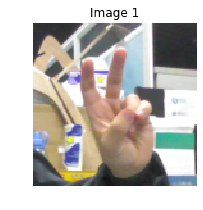

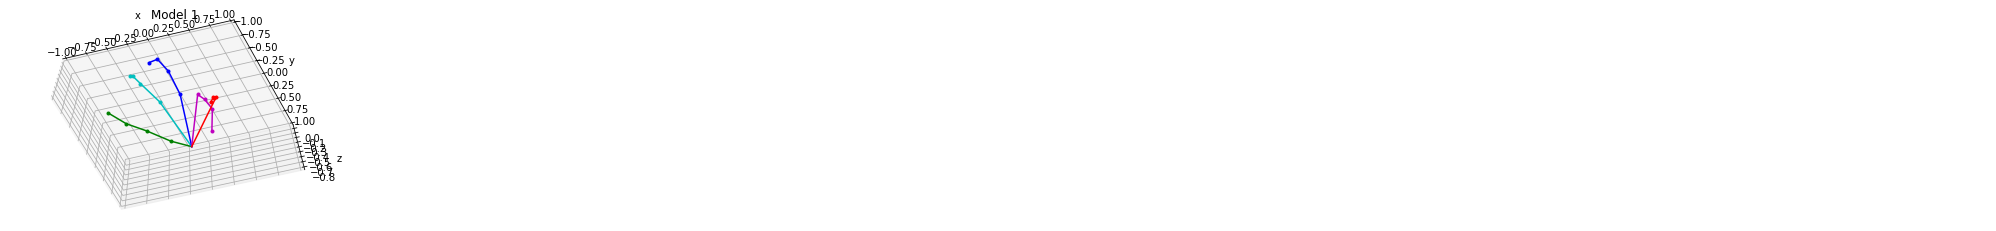

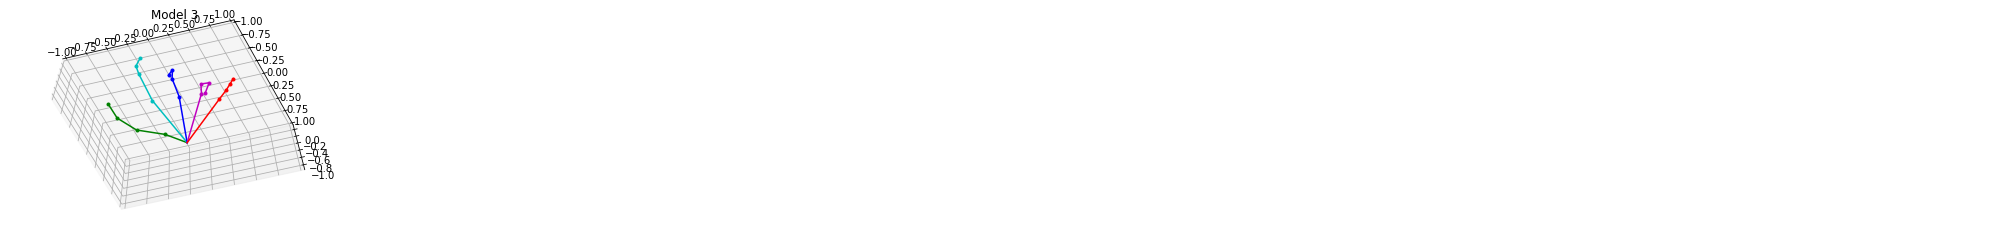

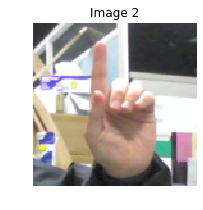

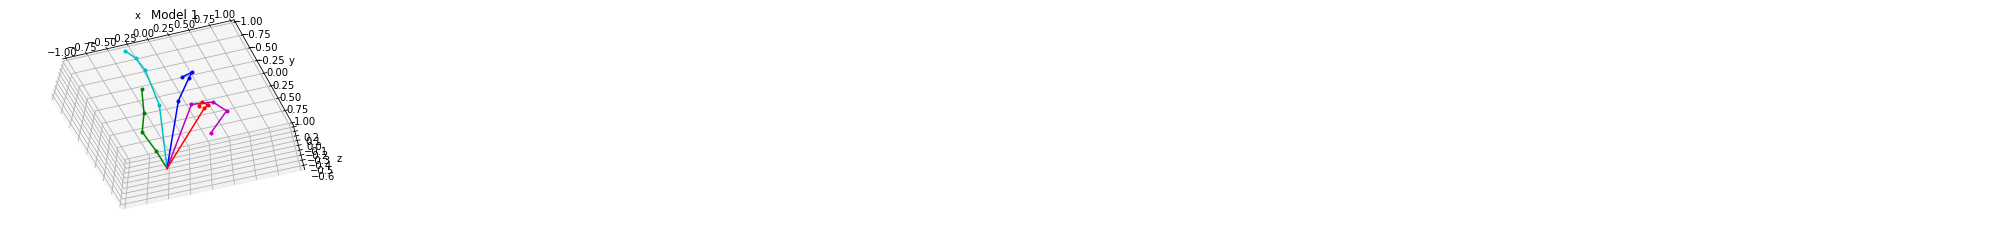

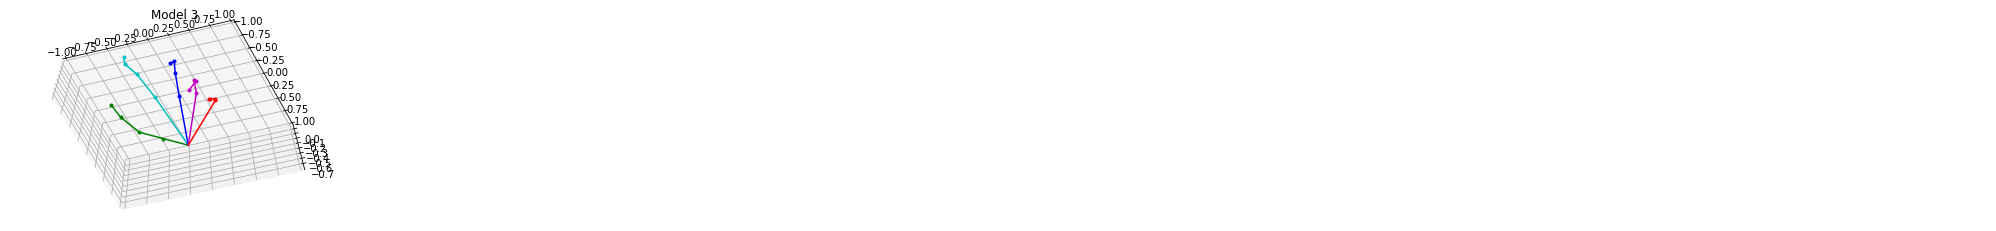

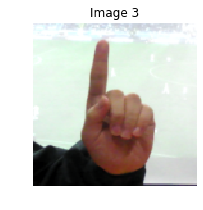

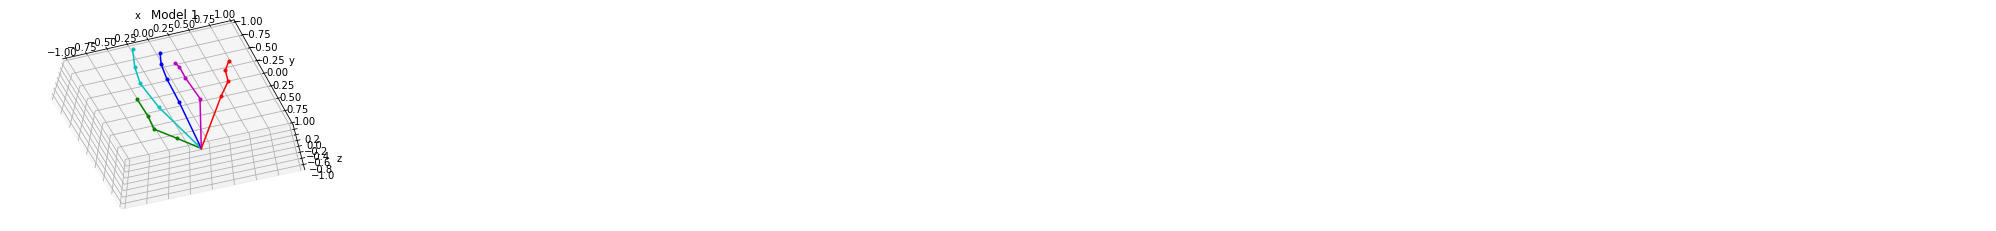

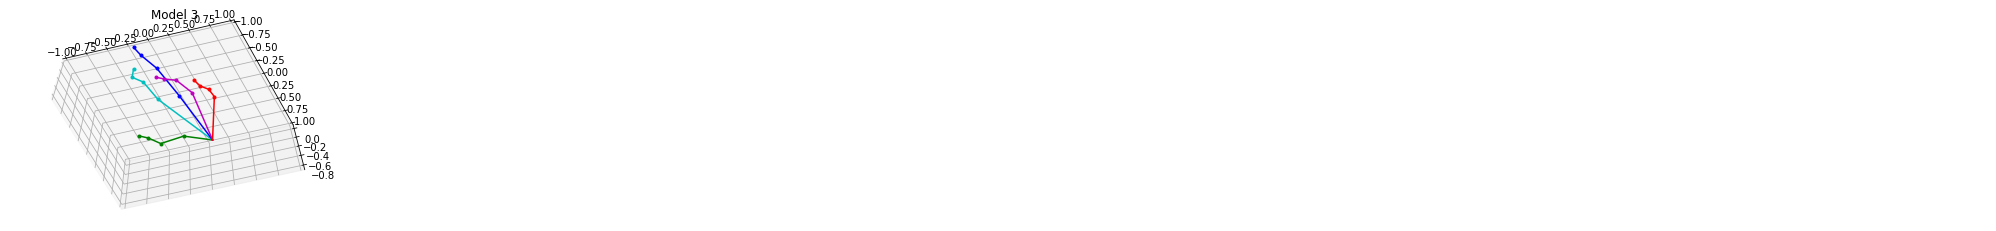

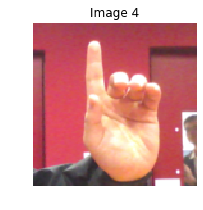

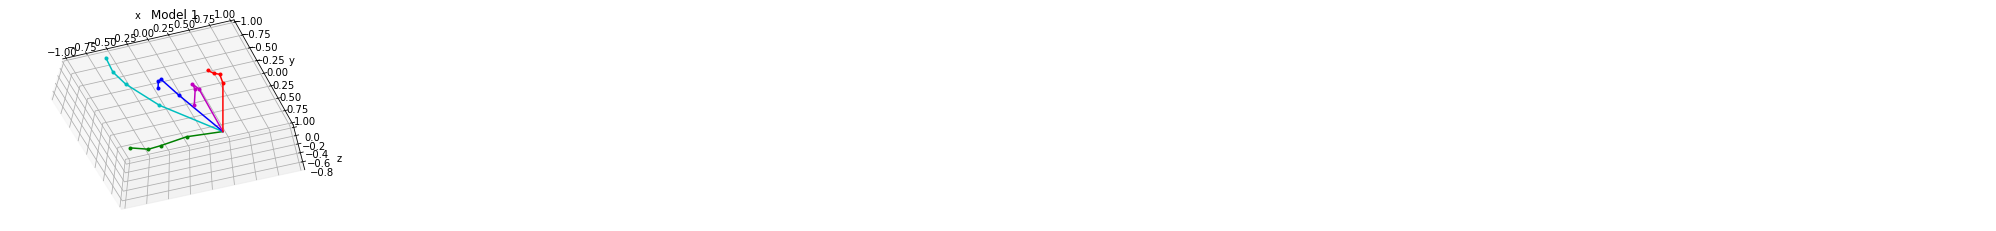

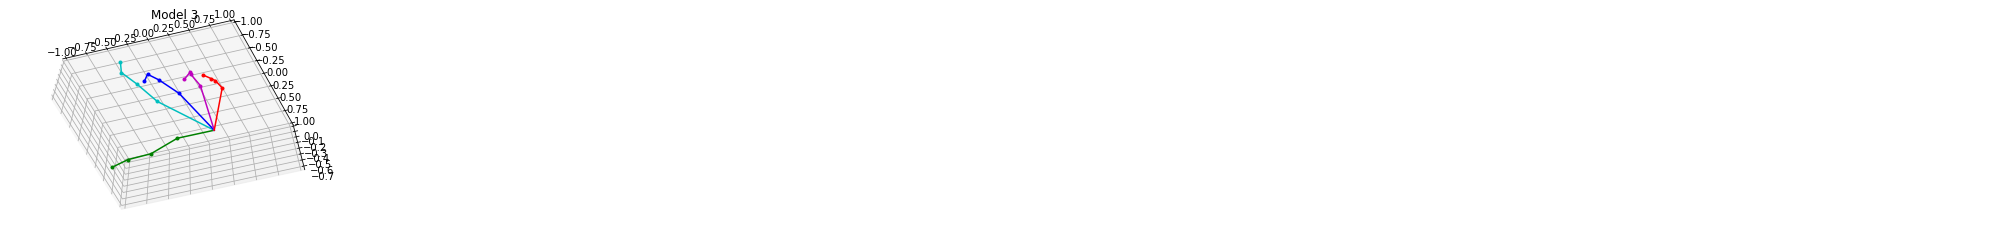

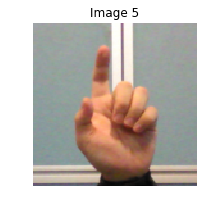

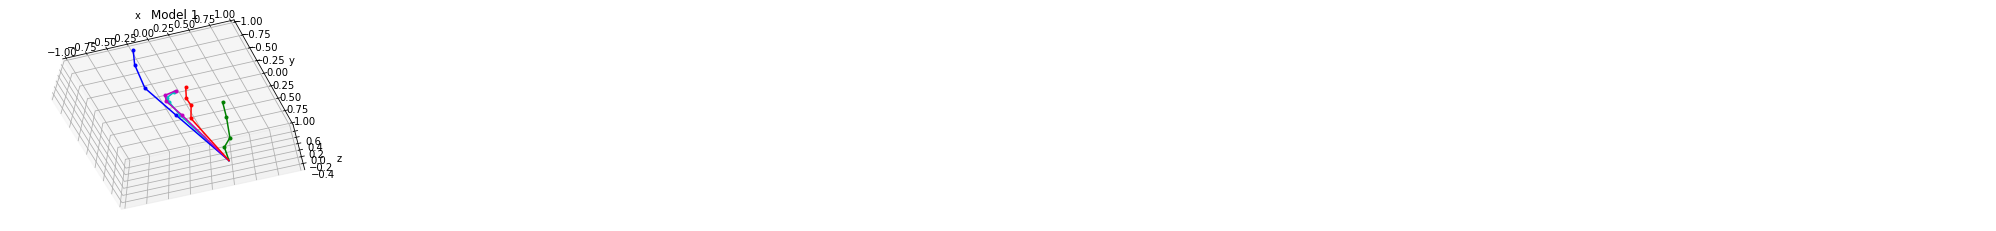

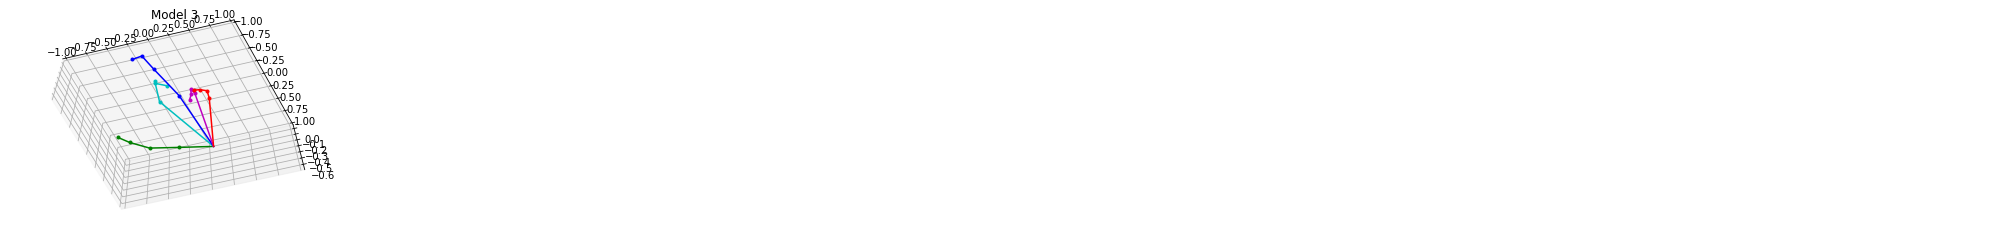

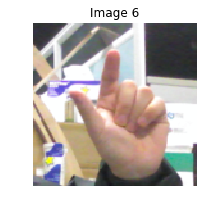

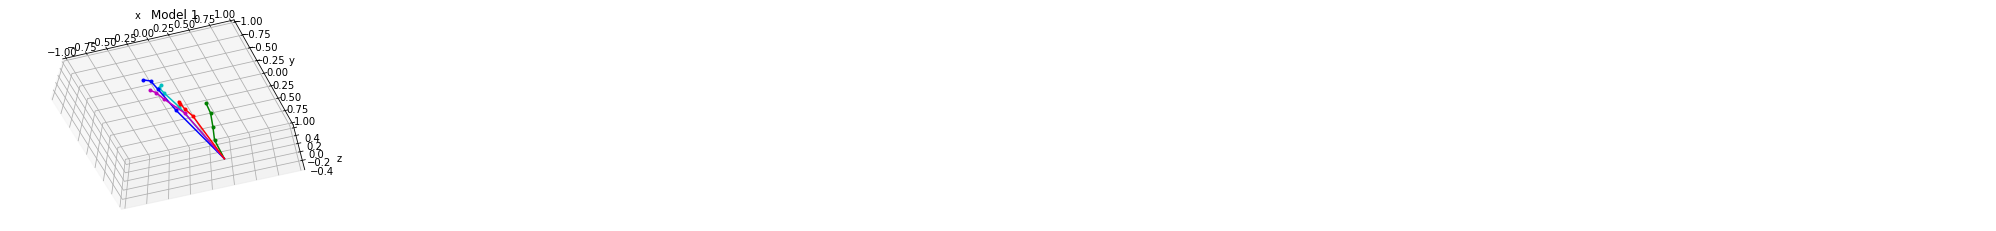

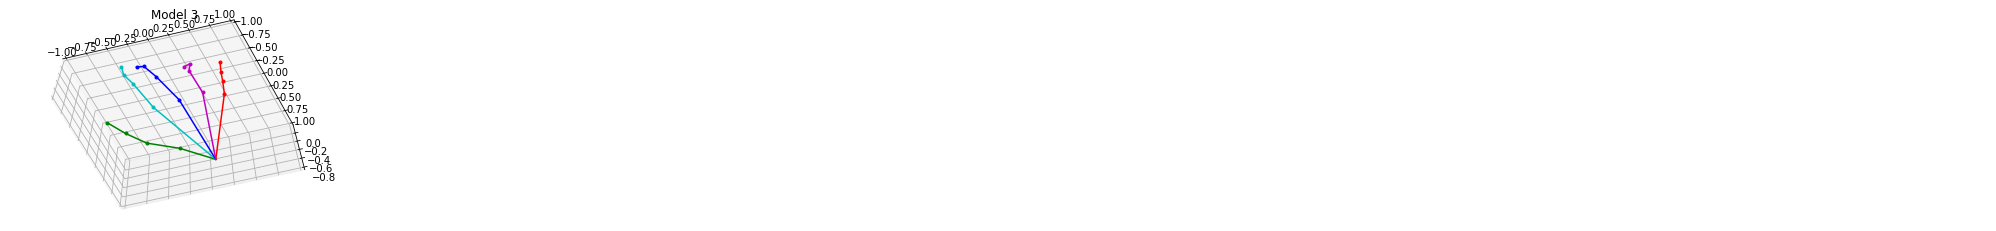

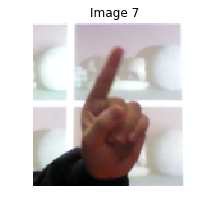

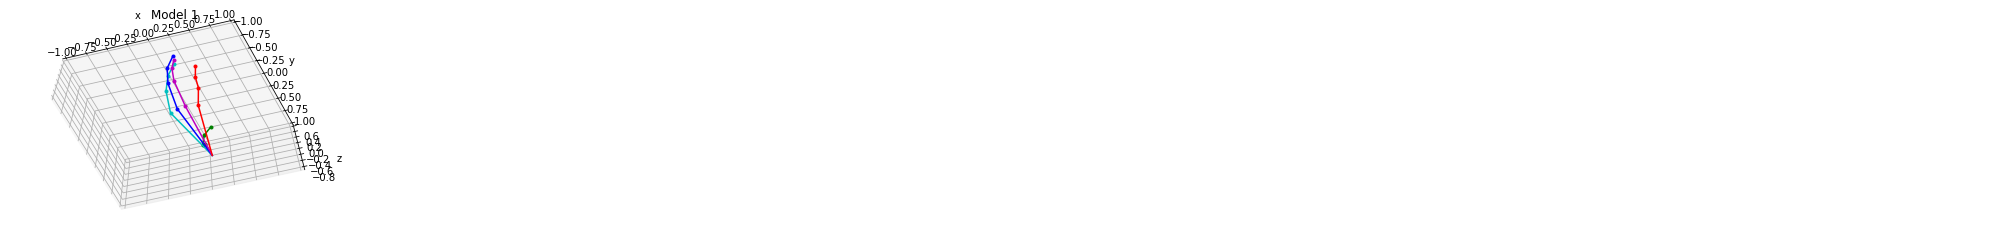

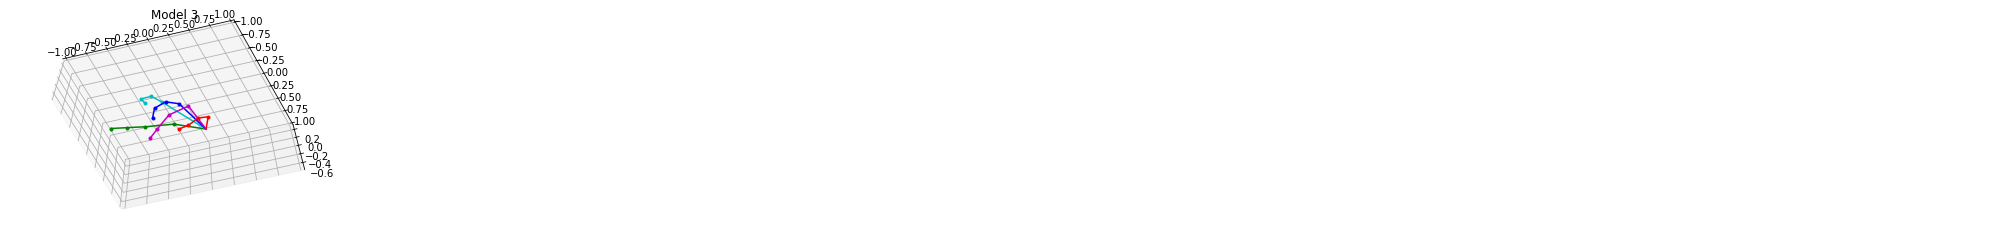

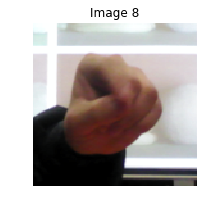

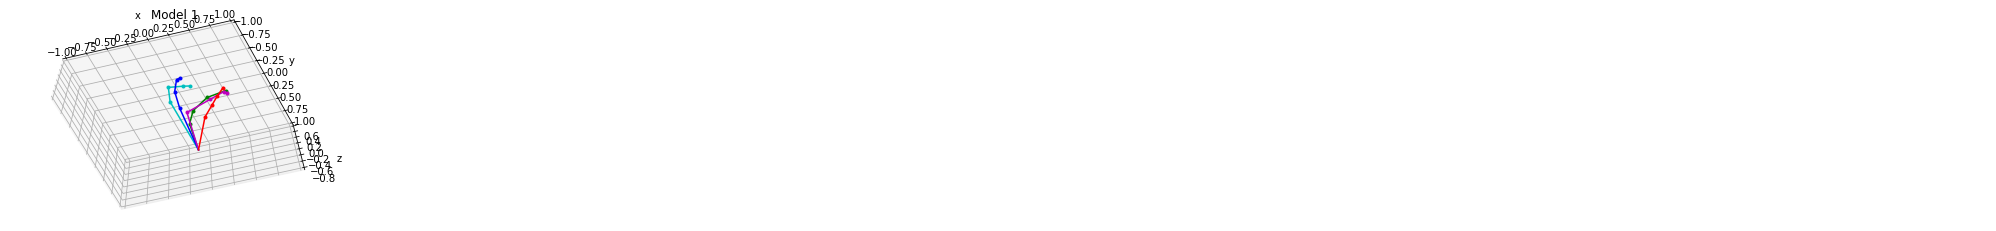

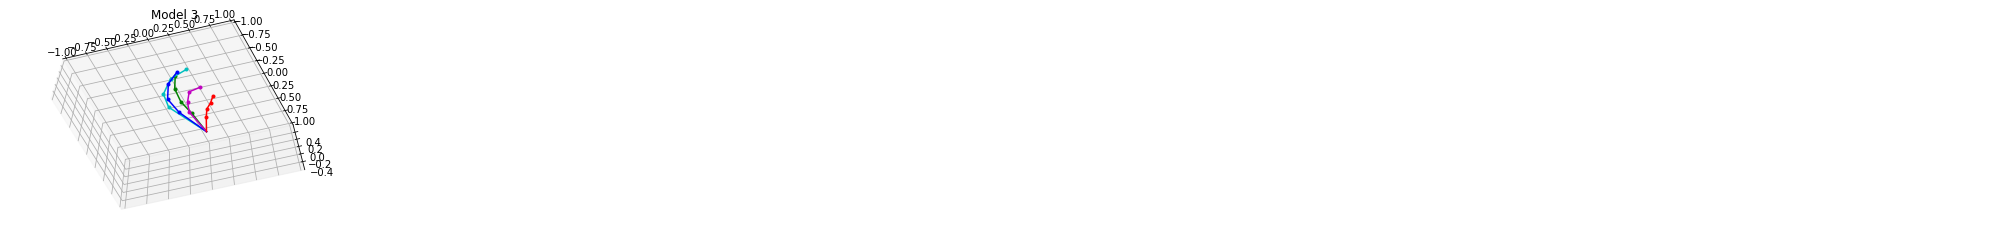

In [84]:
visualize_3d(sample['image'], output['vector_3d'], output3['vector_3d'])

In [49]:
dataset = get_dataloader({'dataset': 'stereo', 'batch_size': 32, 'shuffle': 1},'val')

Images in Stereo dataset: 3000


In [39]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)

/home/ochernytska/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [32]:
def error_by_keypoint(sample, output, label='vector_2d'):
    batch_size = sample['image'].shape[0]
    n_kpoints = 21
    
    if label=='vector_2d':
        dim = 2
    else:
        dim=3
        
    error_keypoint_acc = np.zeros(n_kpoints)
   
    for i in range(batch_size):
        actual = np.reshape(sample[label][i,:].numpy(), (n_kpoints,dim))
        pred = np.reshape(output[label][i,:].detach().cpu().numpy(), (n_kpoints,dim))
        error = (actual - pred)**2
        error = np.sqrt(error.sum(axis=1))
        error_keypoint_acc += error
    
    error_keypoint_acc = error_keypoint_acc / batch_size
    error_total_acc = np.mean(error_keypoint_acc)
    
    return {'keypoint_error': error_keypoint_acc, 
            'total_error': error_total_acc}
        
    

In [298]:
experiment = 'e010'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 8
cuda = int(config['cuda'])
config['dataset'] = 'dexter+object'
dataloader = get_dataloader(config, 'train')
model = get_model(config)
model.load_state_dict(torch.load(config['weights'])['model'])

Images in Dexter+Object dataset: 2497


In [33]:
out = error_by_keypoint(sample, output)
out

{'keypoint_error': array([0.02125036, 0.01950272, 0.02240142, 0.01989787, 0.03089441,
        0.01303271, 0.0166912 , 0.02678314, 0.0359234 , 0.01204698,
        0.01507388, 0.01977978, 0.03355501, 0.01369663, 0.02005914,
        0.02777405, 0.04631021, 0.01581405, 0.01996942, 0.03197025,
        0.04895562]), 'total_error': 0.024351536153907154}

In [299]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)

/home/ochernytska/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


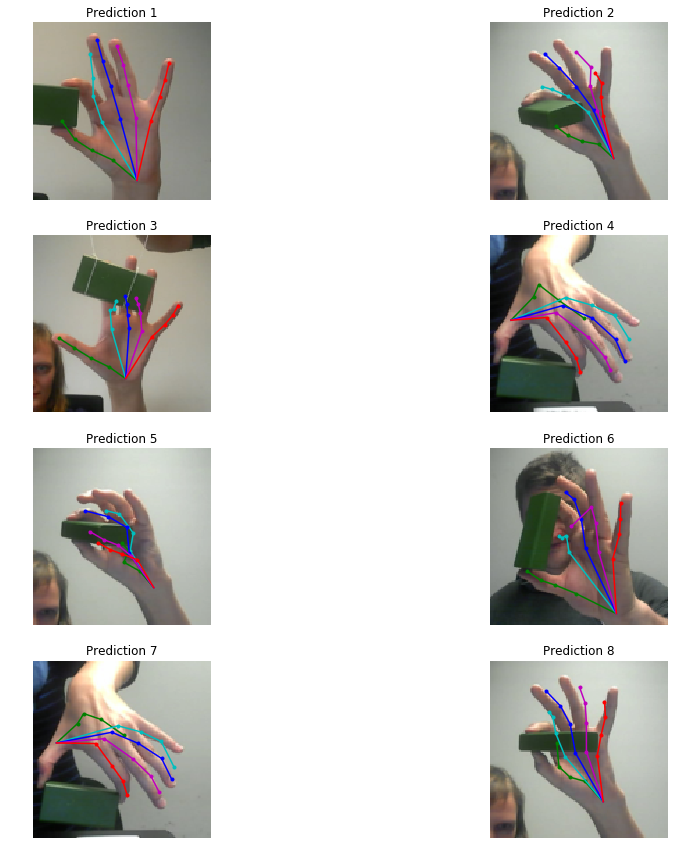

In [300]:
vector = output['vector_2d'].detach().cpu()
sample['image'] = sample['image'].cpu()
visualize_2d(sample['image'], vector)

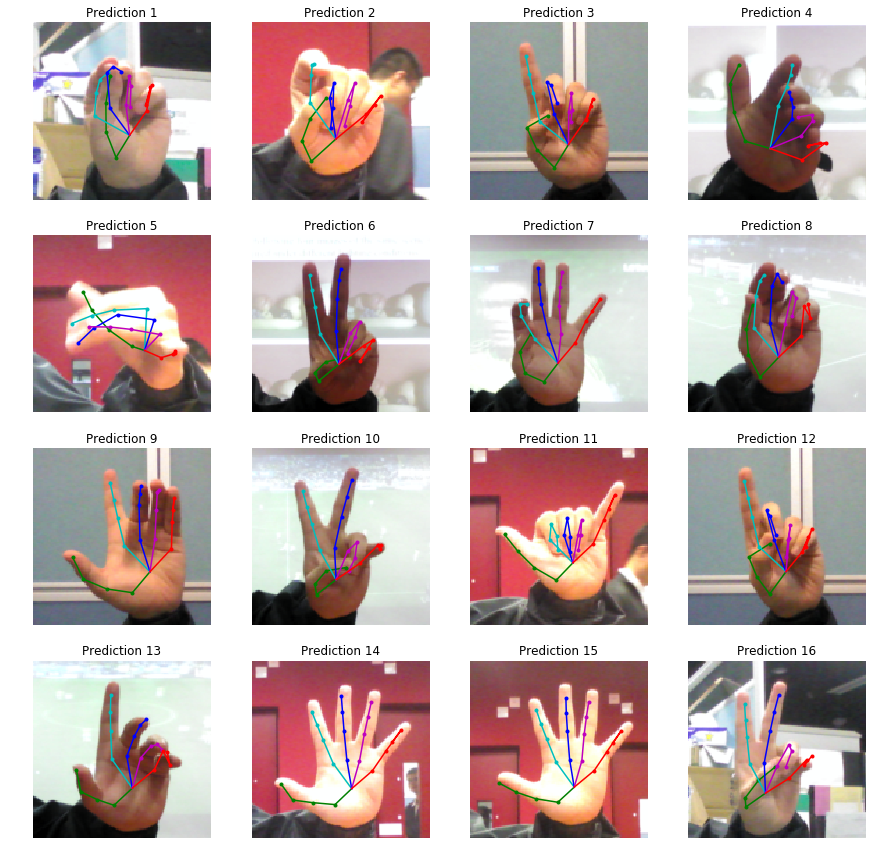

In [45]:
vector = sample['vector_2d']
sample['image'] = sample['image'].cpu()
visualize_2d(sample['image'], vector)

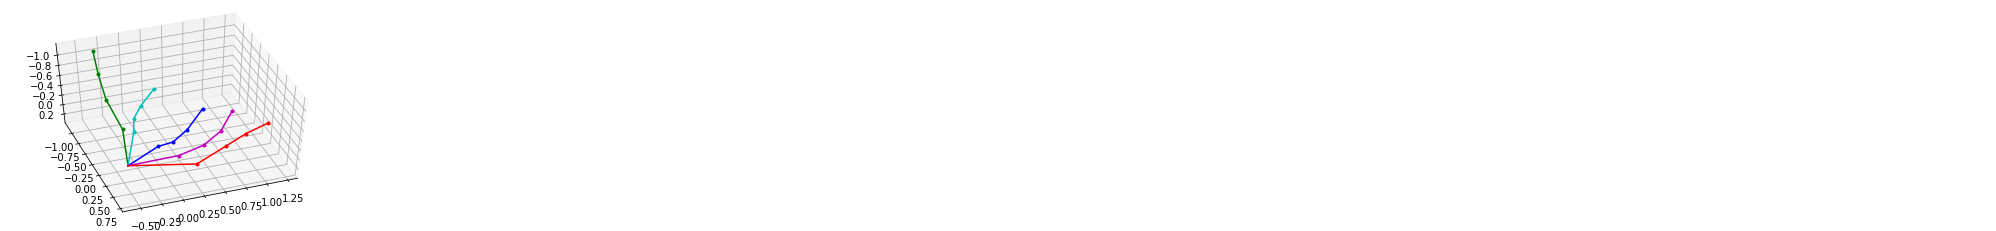

In [45]:
from mpl_toolkits.mplot3d import Axes3D
vectors_3d = sample['vector_3d']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
keypoints = np.reshape(vectors_3d[13,:].numpy(), (21,3))
plt.plot(keypoints[:5,0], keypoints[:5,1], keypoints[:5,2],  'g')
plt.plot(keypoints[1:5,0], keypoints[1:5,1], keypoints[1:5,2],  'go', ms=3)
plt.plot(keypoints[[0,5,6,7,8],0], keypoints[[0,5,6,7,8],1], keypoints[[0,5,6,7,8],2],  'c')
plt.plot(keypoints[5:9,0], keypoints[5:9,1], keypoints[5:9,2],  'co', ms=3)
plt.plot(keypoints[[0,9,10,11,12],0], keypoints[[0,9,10,11,12],1], keypoints[[0,9,10,11,12],2],  'b')
plt.plot(keypoints[9:13,0], keypoints[9:13,1], keypoints[9:13,2],  'bo', ms=3)
plt.plot(keypoints[[0,13,14,15,16],0], keypoints[[0,13,14,15,16],1], keypoints[[0,13,14,15,16],2],  'm')
plt.plot(keypoints[13:17,0], keypoints[13:17,1], keypoints[13:17,2],  'mo', ms=3)
plt.plot(keypoints[[0,17,18,19,20],0], keypoints[[0,17,18,19,20],1], keypoints[[0,17,18,19,20],2], 'r')
plt.plot(keypoints[17:21,0], keypoints[17:21,1], keypoints[17:21,2],  'ro', ms=3)
ax.view_init(310,110)
#plt.axis('off')
plt.show()

In [29]:
img = np.ones((128,128,3)) * 255
img.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


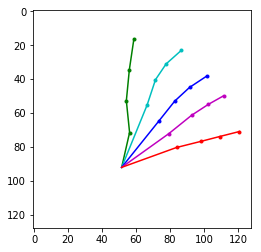

In [30]:
vectors_2d = sample['vector_2d']
keypoints = np.reshape(vectors_2d[13,:].numpy() * 128, (21,2))
plt.plot(keypoints[:5,0], keypoints[:5,1], 'g') 
plt.plot(keypoints[1:5,0], keypoints[1:5,1], 'go', ms=3)
plt.plot(keypoints[[0,5,6,7,8],0], keypoints[[0,5,6,7,8],1], 'c') 
plt.plot(keypoints[5:9,0], keypoints[5:9,1], 'co', ms=3)
plt.plot(keypoints[[0,9,10,11,12],0], keypoints[[0,9,10,11,12],1], 'b') 
plt.plot(keypoints[9:13,0], keypoints[9:13,1], 'bo', ms=3)
plt.plot(keypoints[[0,13,14,15,16],0], keypoints[[0,13,14,15,16],1], 'm') 
plt.plot(keypoints[13:17,0], keypoints[13:17,1], 'mo', ms=3)
plt.plot(keypoints[[0,17,18,19,20],0], keypoints[[0,17,18,19,20],1], 'r') 
plt.plot(keypoints[17:21,0], keypoints[17:21,1], 'ro', ms=3)
plt.imshow(img)
plt.axis()
plt.show()

In [ ]:
def visualize_2d(images, vectors_2d):
    
    img_num, _, img_size, _ = images.shape
    plt.figure(figsize=(15,15))
    cols = 4
    rows = np.ceil(img_num/4)
    
    for i in range(img_num):
        img = images[i,:,:,:]
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        
        plt.subplot(cols,rows, i+1)
        plt.imshow(img)
        keypoints = np.reshape(vectors_2d[i,:].numpy() * img_size, (21,2))
        plt.plot(keypoints[:5,0], keypoints[:5,1], 'g') 
        plt.plot(keypoints[1:5,0], keypoints[1:5,1], 'go', ms=3)
        plt.plot(keypoints[[0,5,6,7,8],0], keypoints[[0,5,6,7,8],1], 'c') 
        plt.plot(keypoints[5:9,0], keypoints[5:9,1], 'co', ms=3)
        plt.plot(keypoints[[0,9,10,11,12],0], keypoints[[0,9,10,11,12],1], 'b') 
        plt.plot(keypoints[9:13,0], keypoints[9:13,1], 'bo', ms=3)
        plt.plot(keypoints[[0,13,14,15,16],0], keypoints[[0,13,14,15,16],1], 'm') 
        plt.plot(keypoints[13:17,0], keypoints[13:17,1], 'mo', ms=3)
        plt.plot(keypoints[[0,17,18,19,20],0], keypoints[[0,17,18,19,20],1], 'r') 
        plt.plot(keypoints[17:21,0], keypoints[17:21,1], 'ro', ms=3)
        plt.axis('off')
        plt.title('Prediction ' + str(i+1))
        
        plt.imshow(img)
    
    plt.show()    
    return  

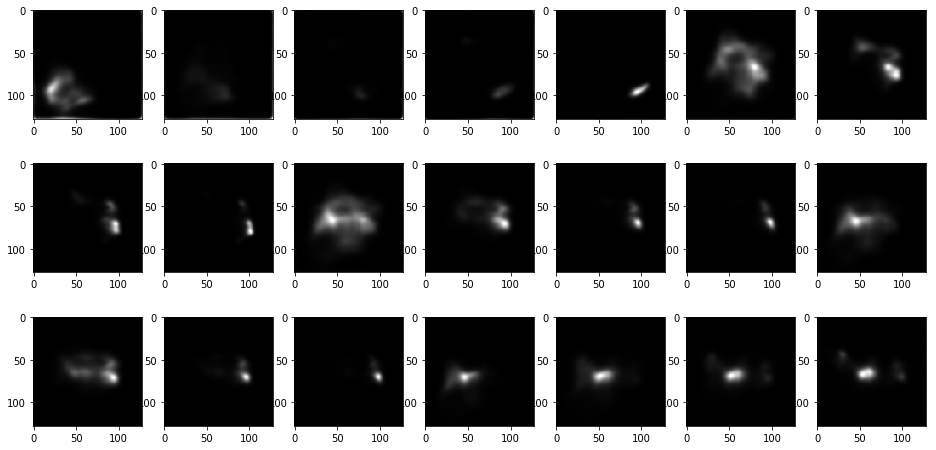

In [9]:
plt.figure(figsize=[16,8])
heatmaps = output['heatmaps'].detach().cpu()
for x in range(21):
    plt.subplot(3,7,x+1)
    heatmap = heatmaps[0,x,:,:].numpy()
    plt.imshow(heatmap, cmap = 'gray')
plt.show()

In [50]:
experiment = 'e013'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

model2 = get_model(config)
model2.load_state_dict(torch.load(config['weights'])['model'])

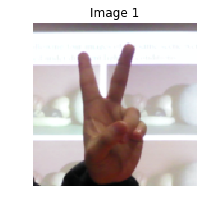

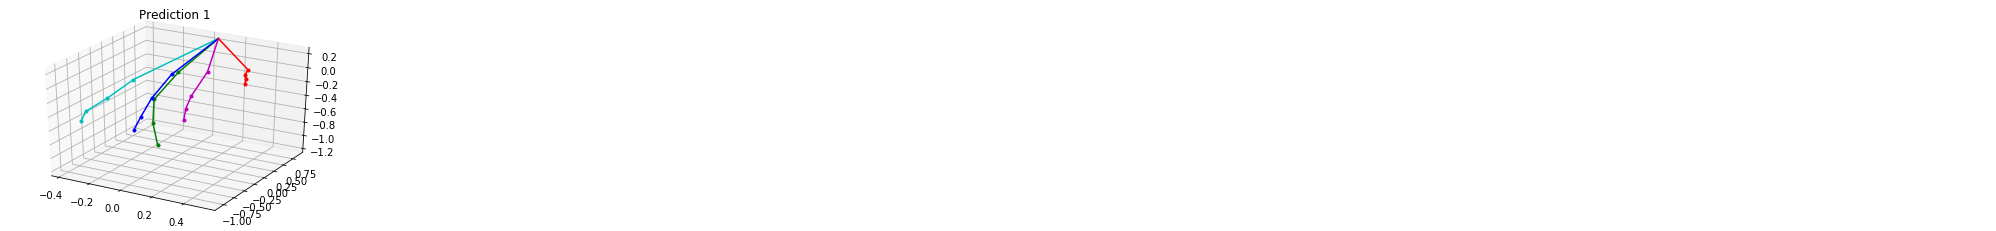

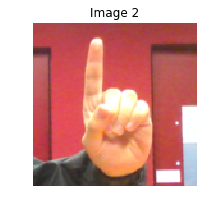

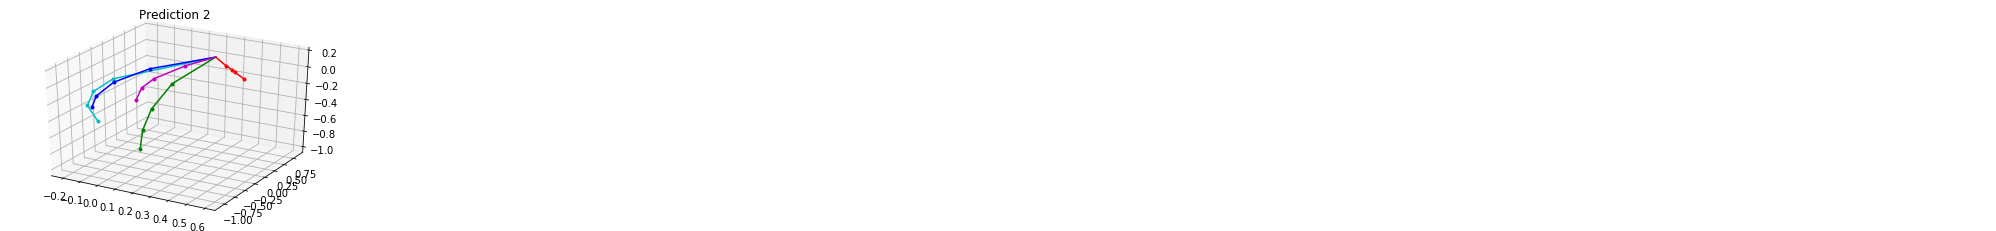

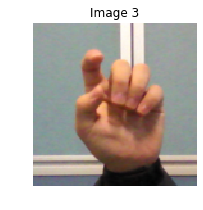

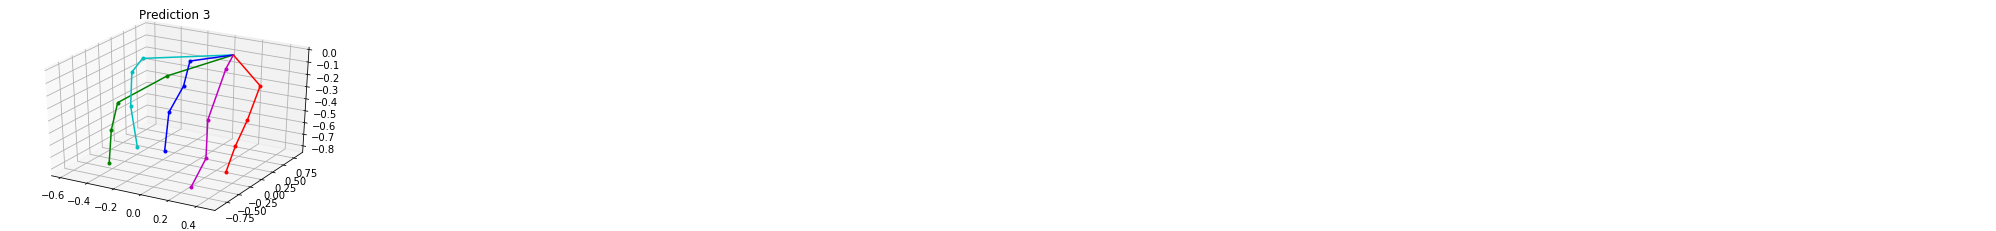

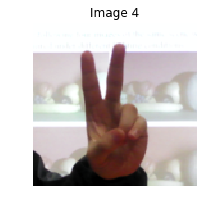

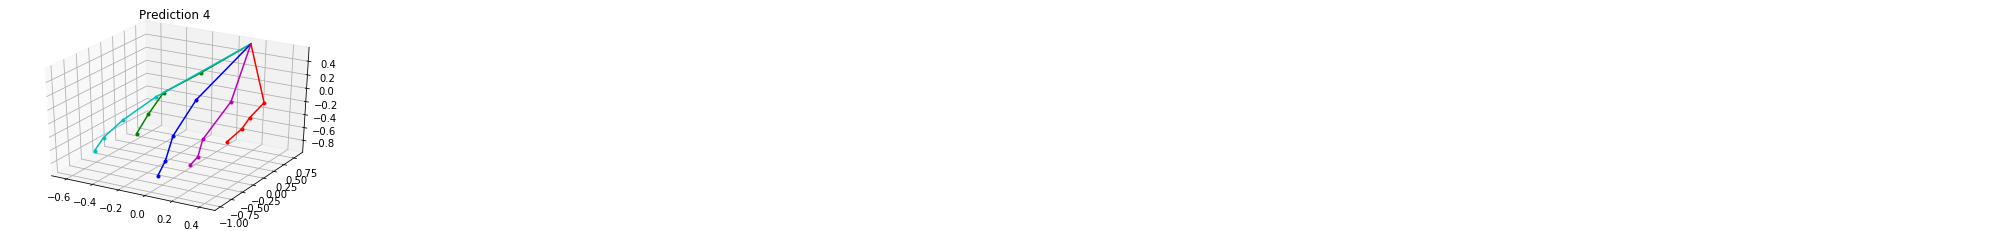

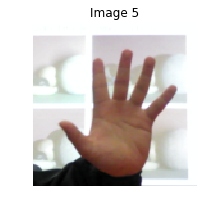

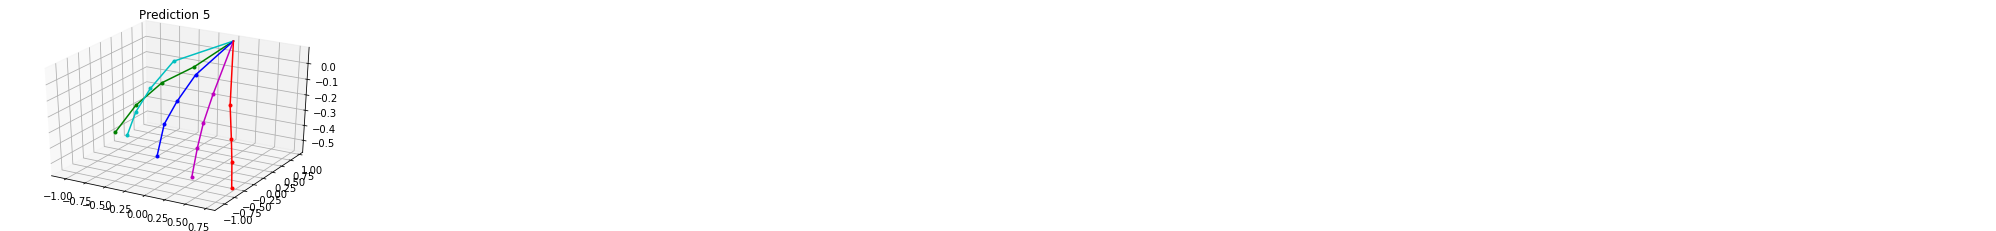

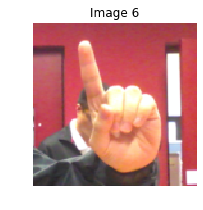

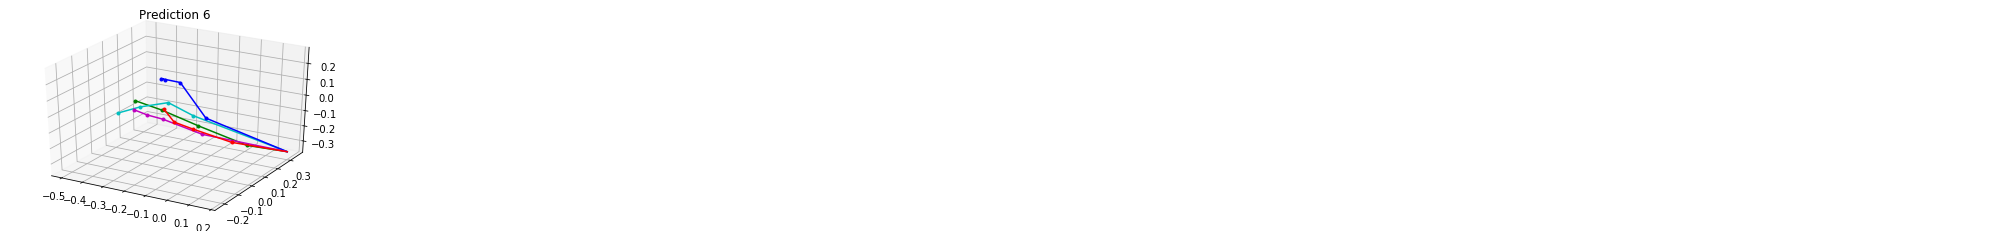

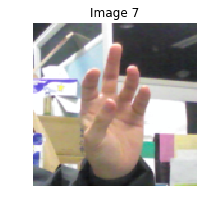

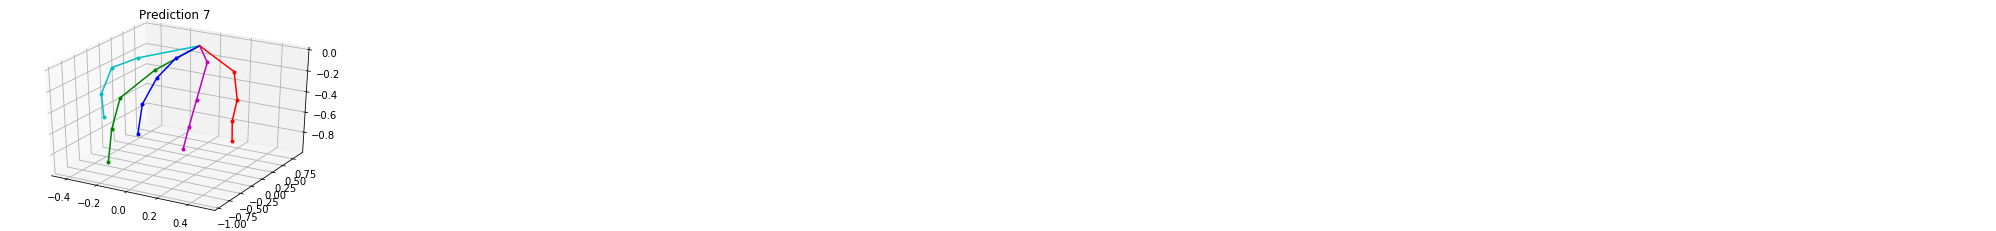

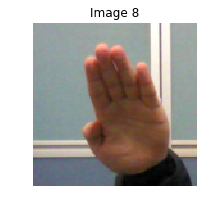

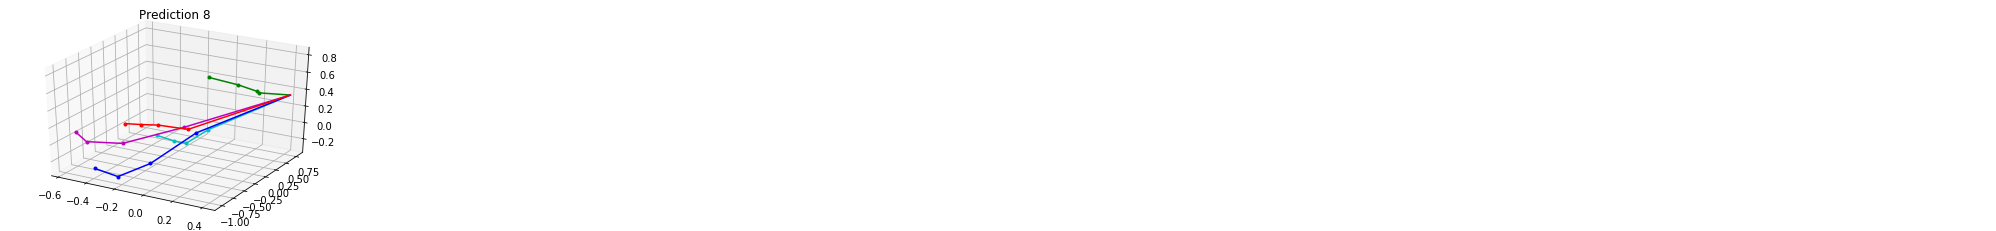

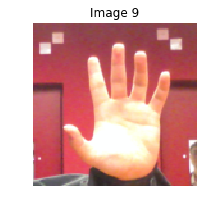

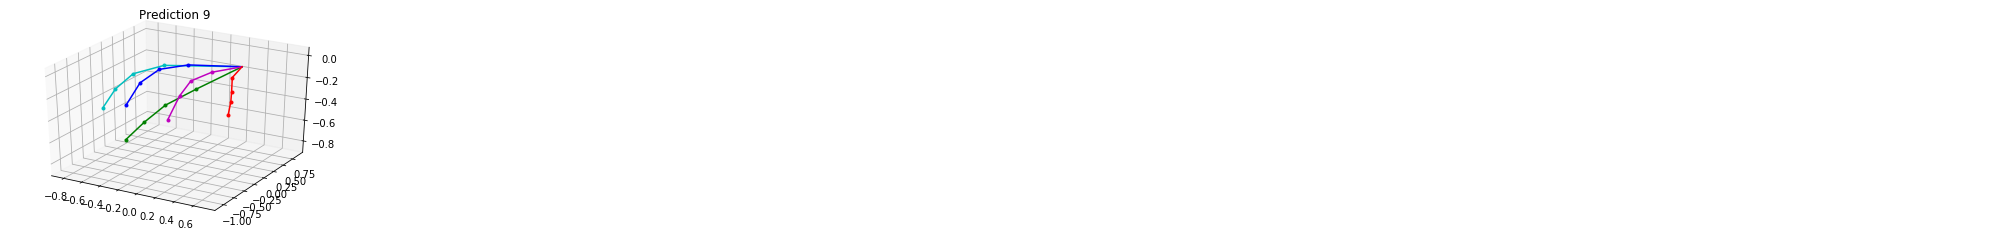

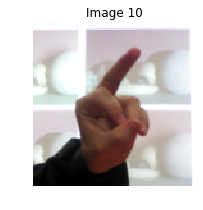

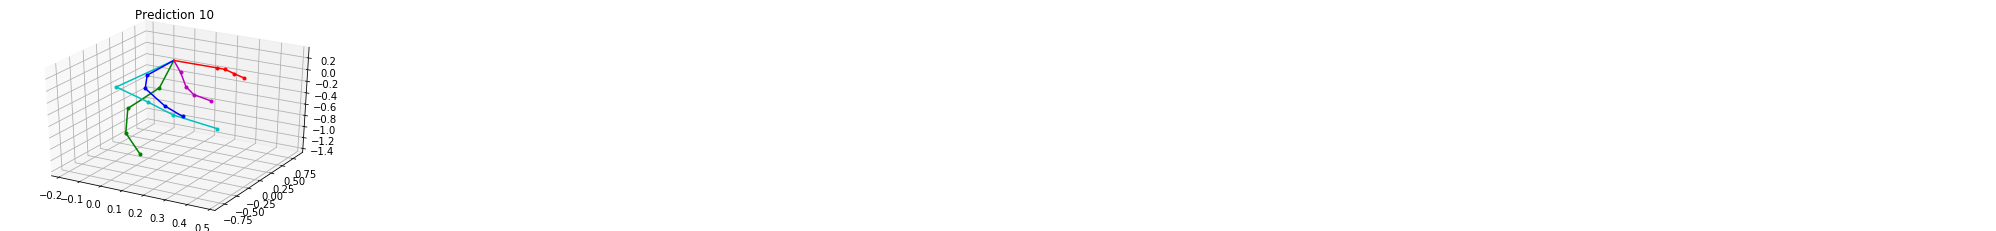

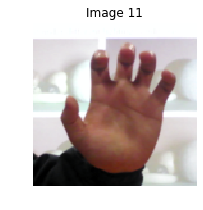

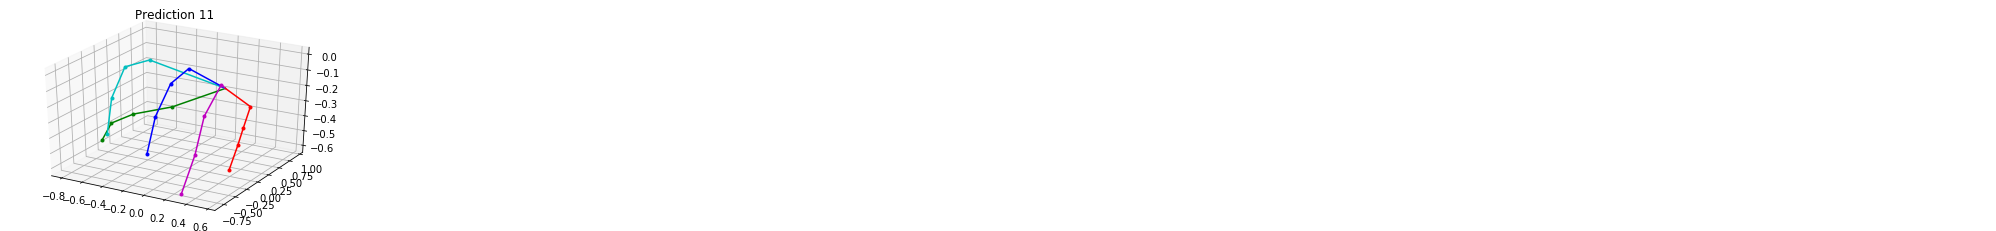

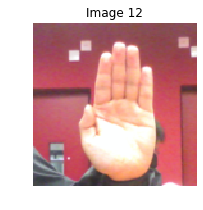

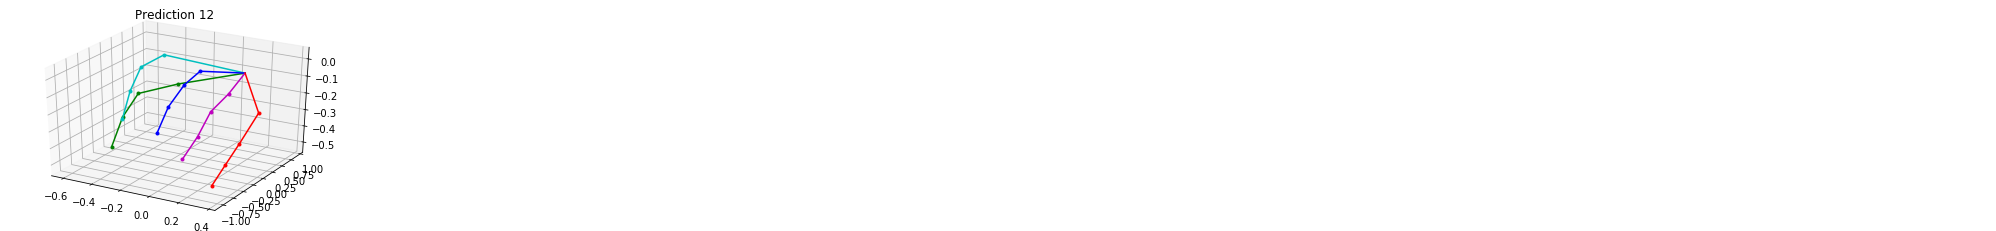

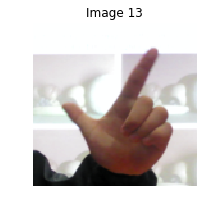

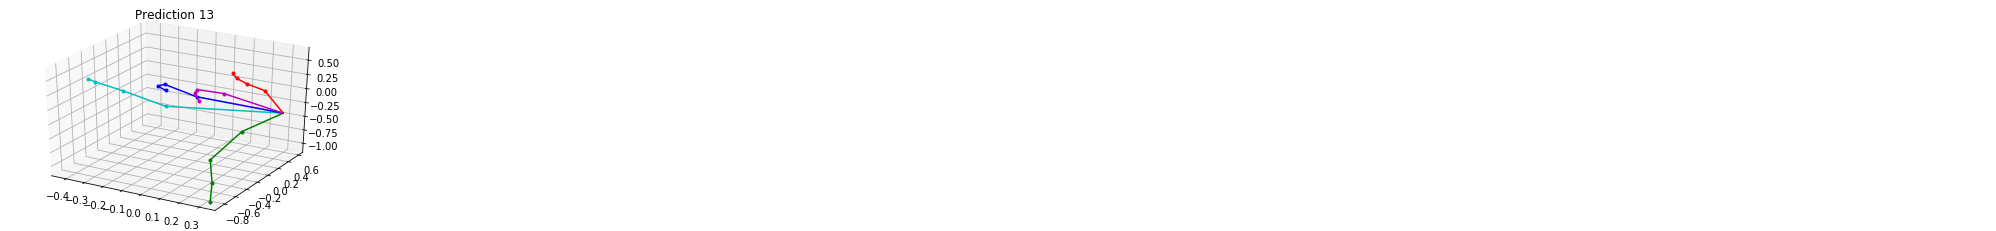

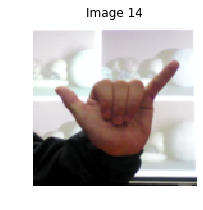

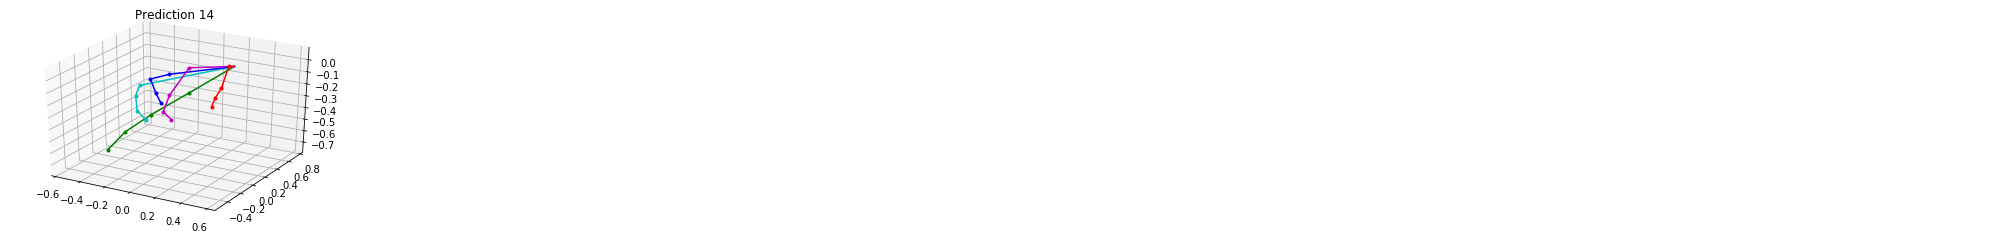

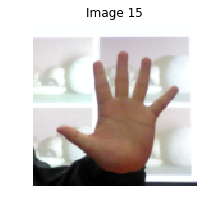

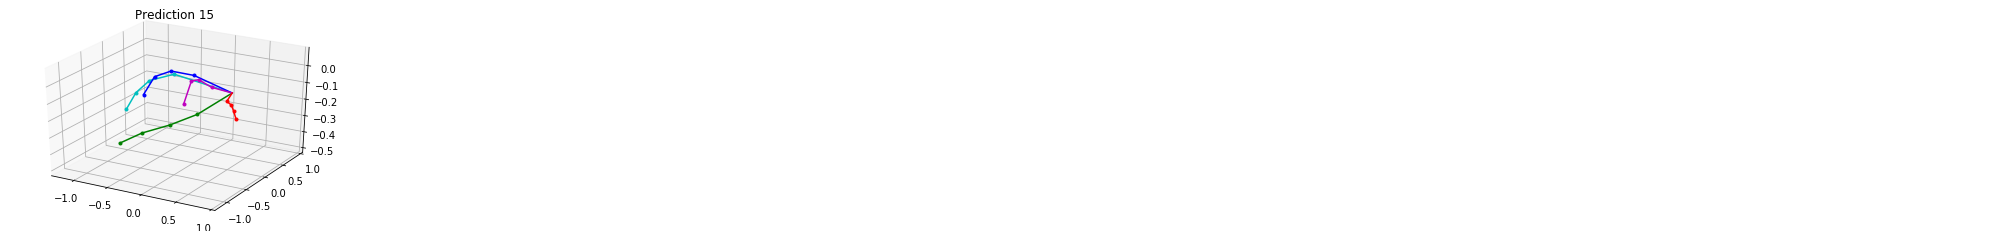

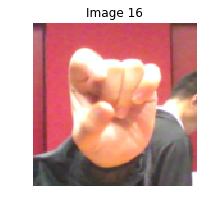

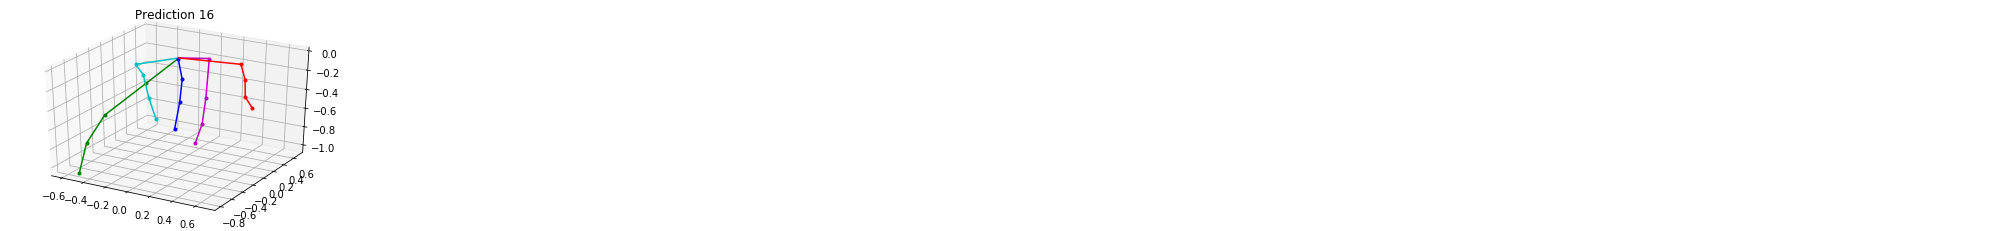

In [52]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model2(sample)

vector = output['vector_3d'].detach().cpu()
sample['image'] = sample['image'].cpu()
visualize_3d(sample['image'], vector)

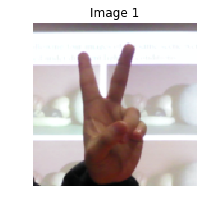

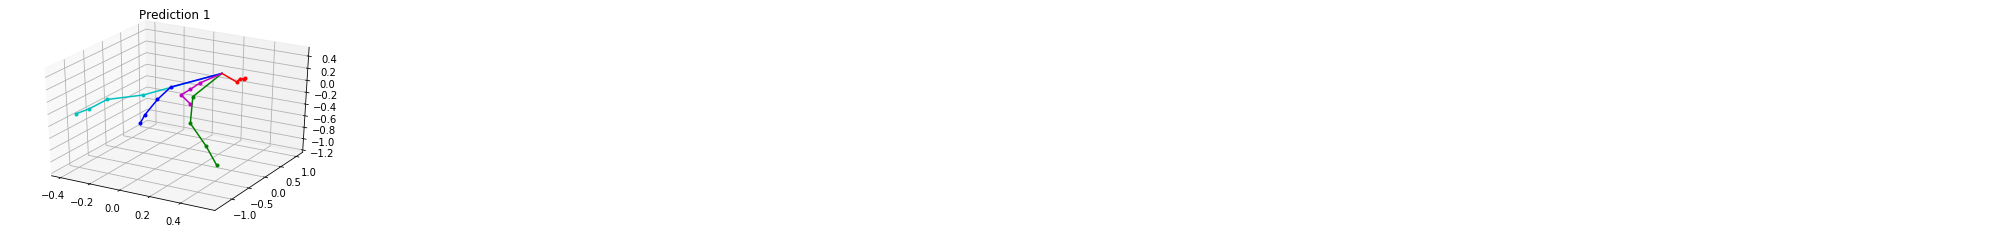

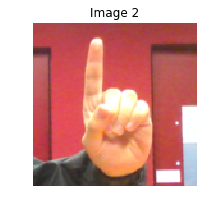

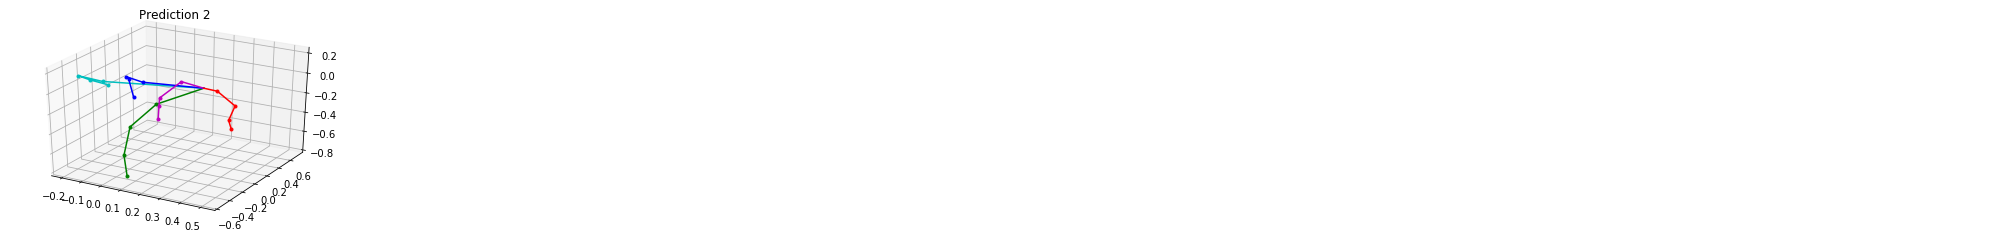

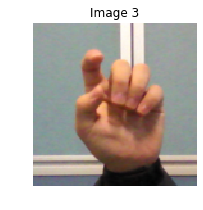

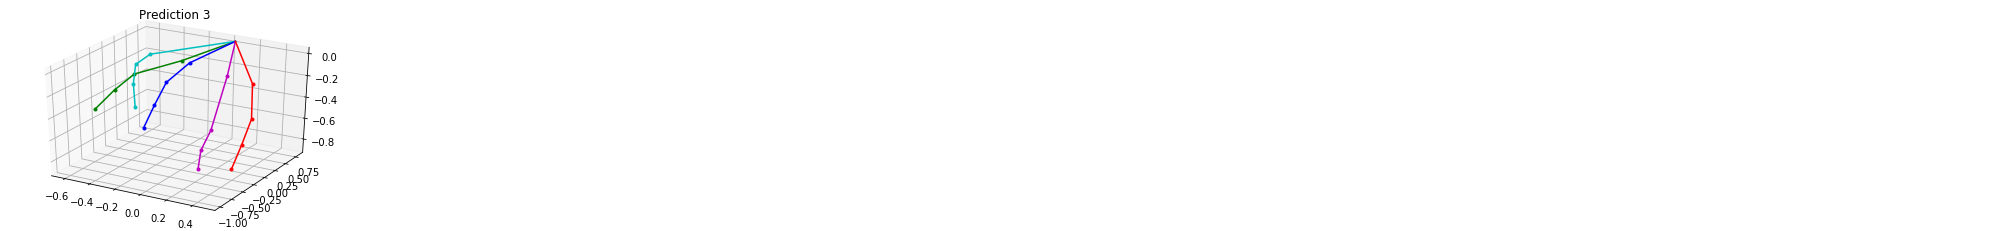

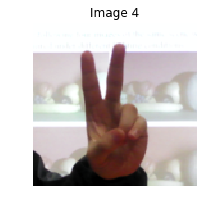

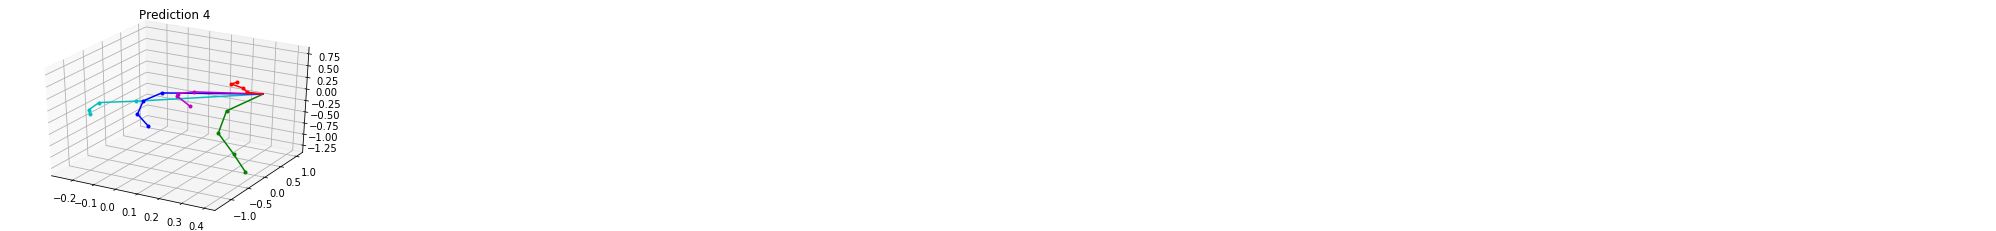

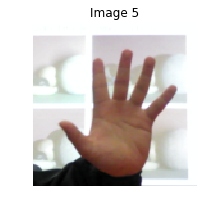

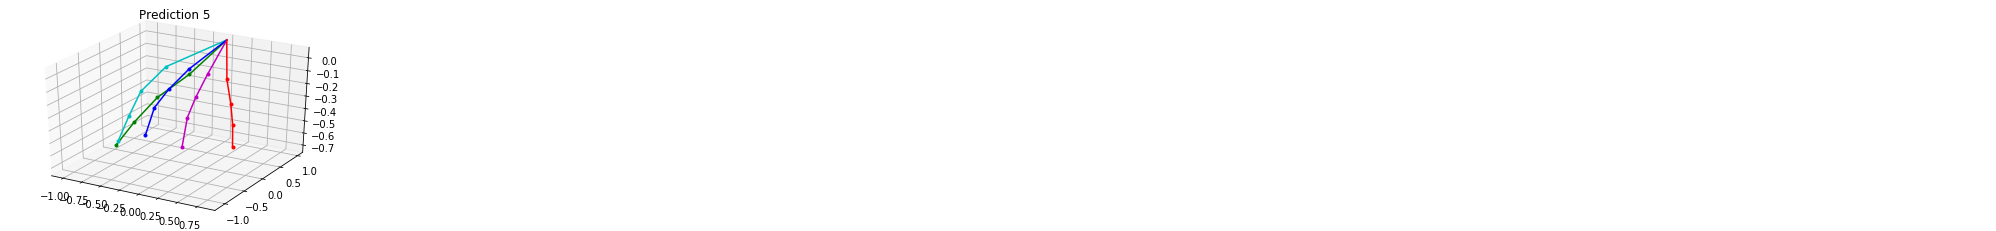

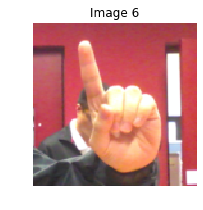

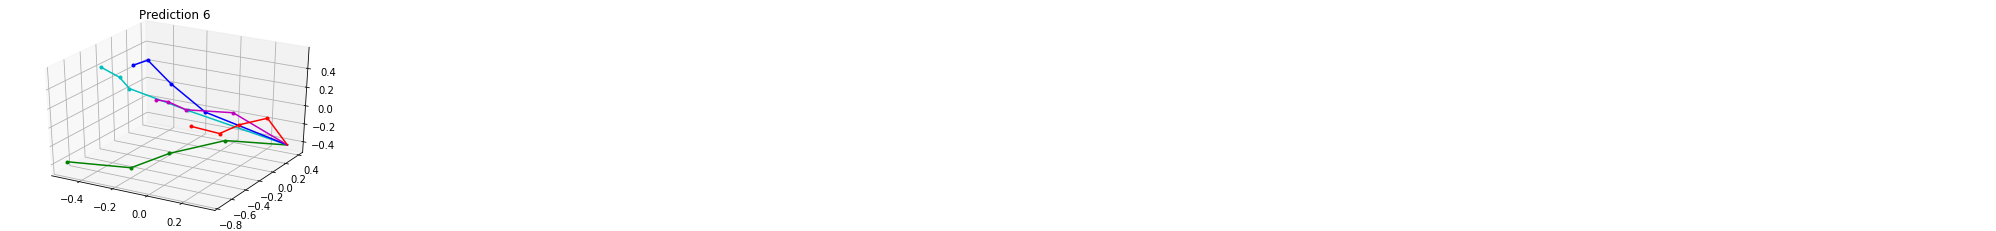

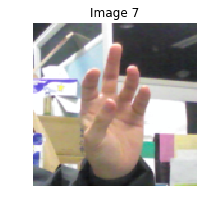

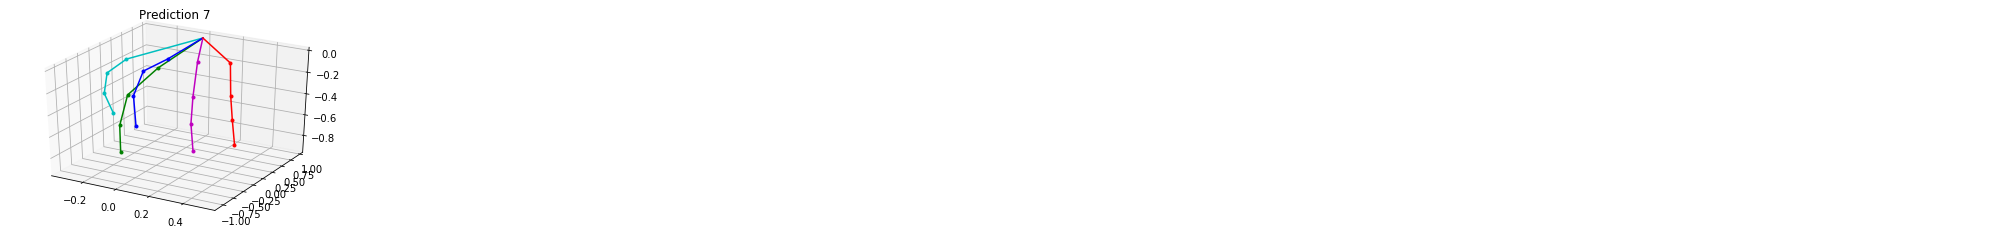

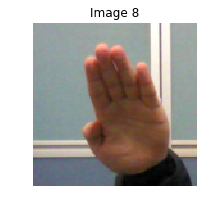

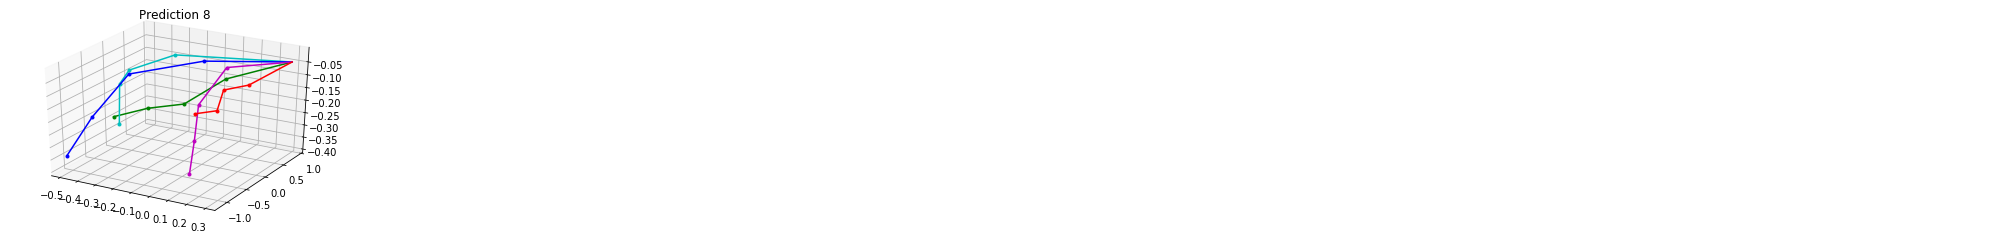

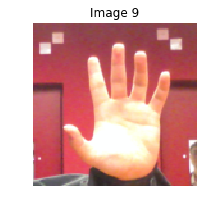

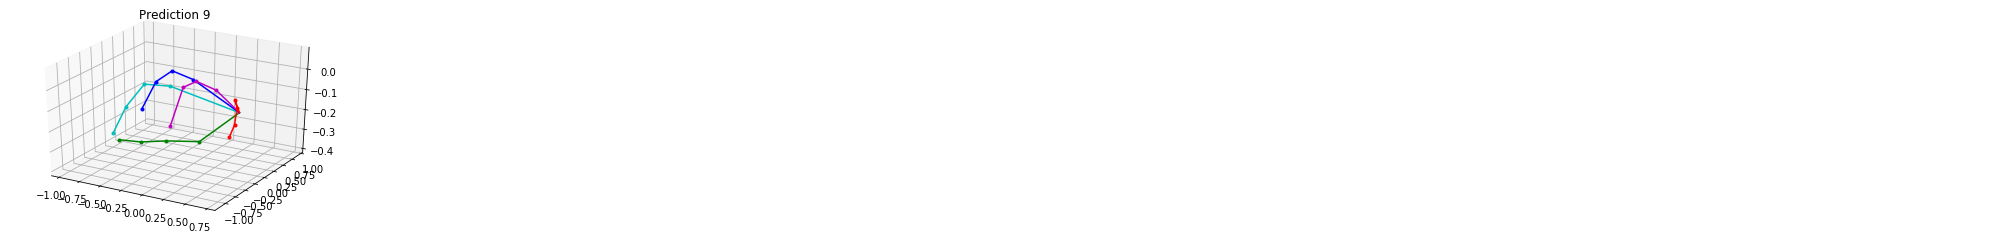

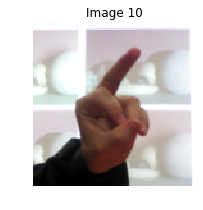

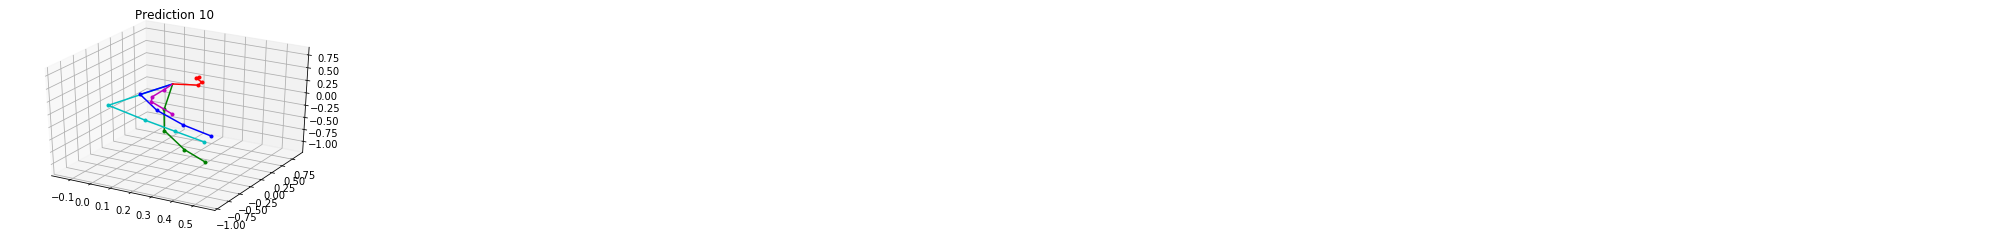

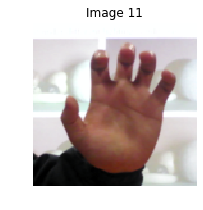

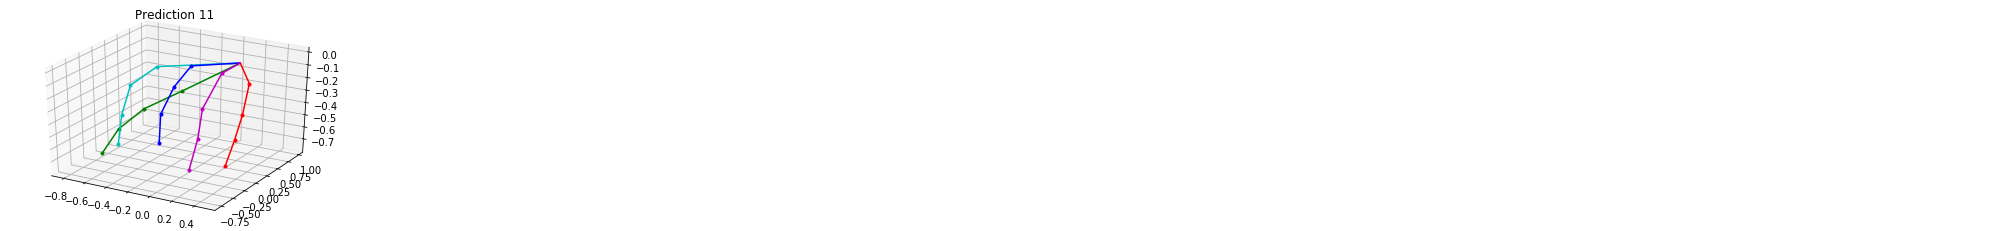

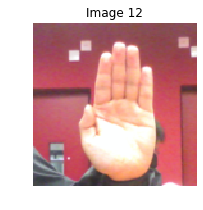

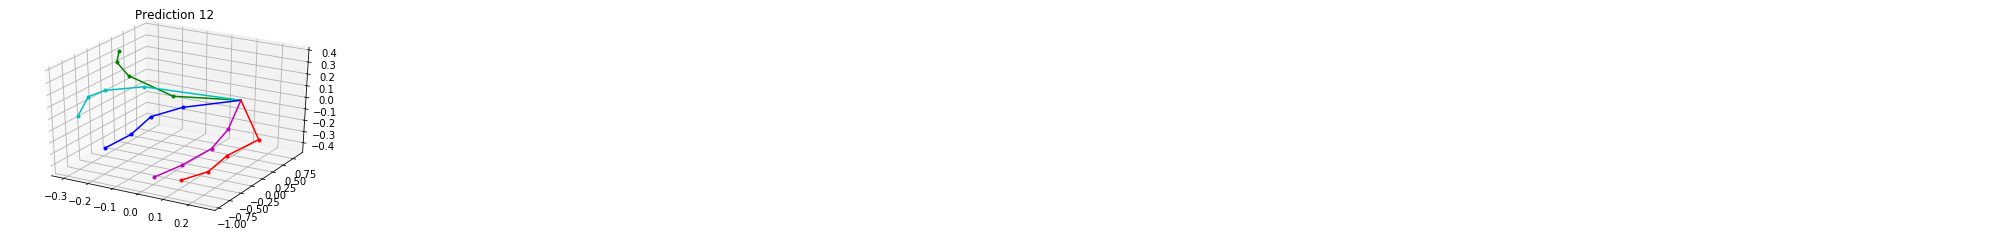

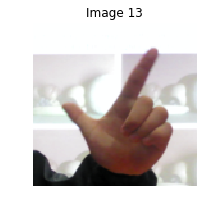

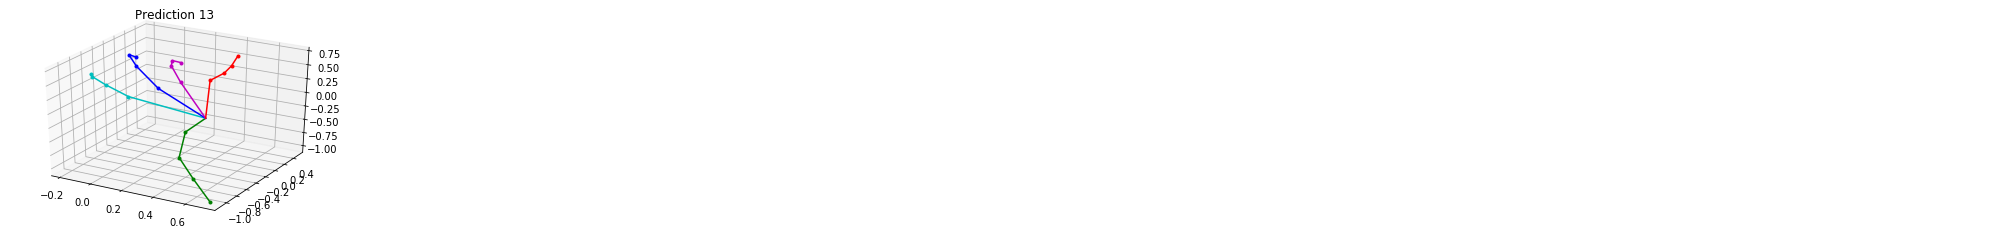

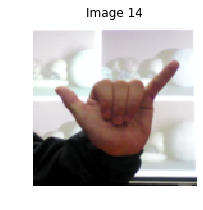

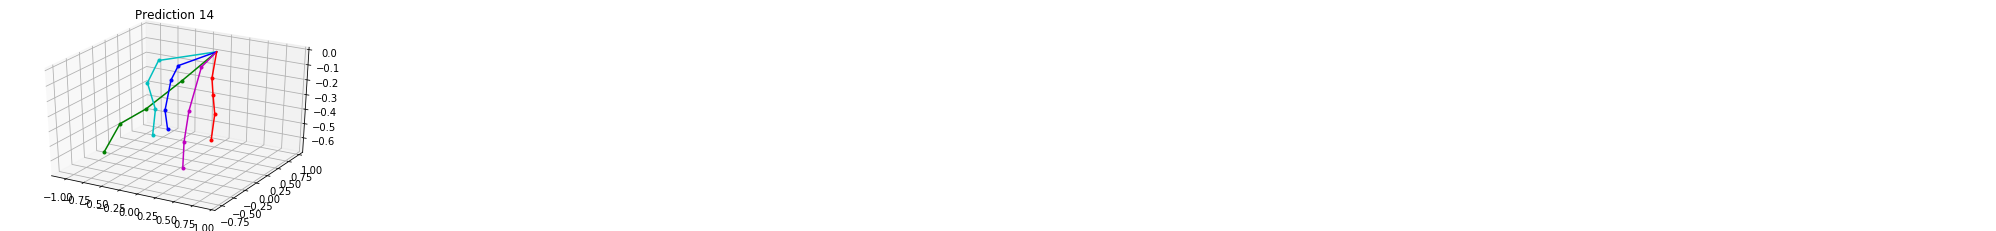

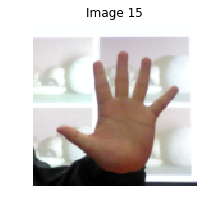

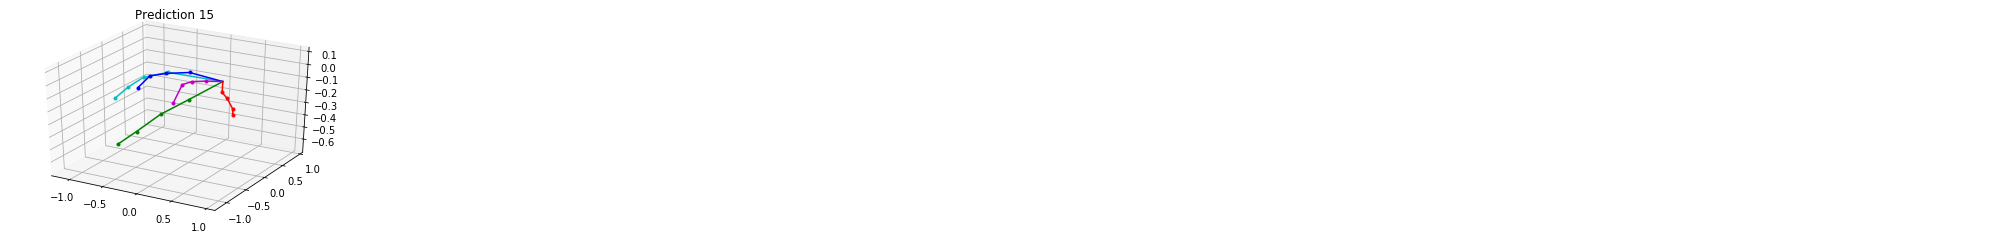

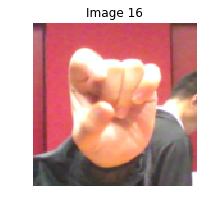

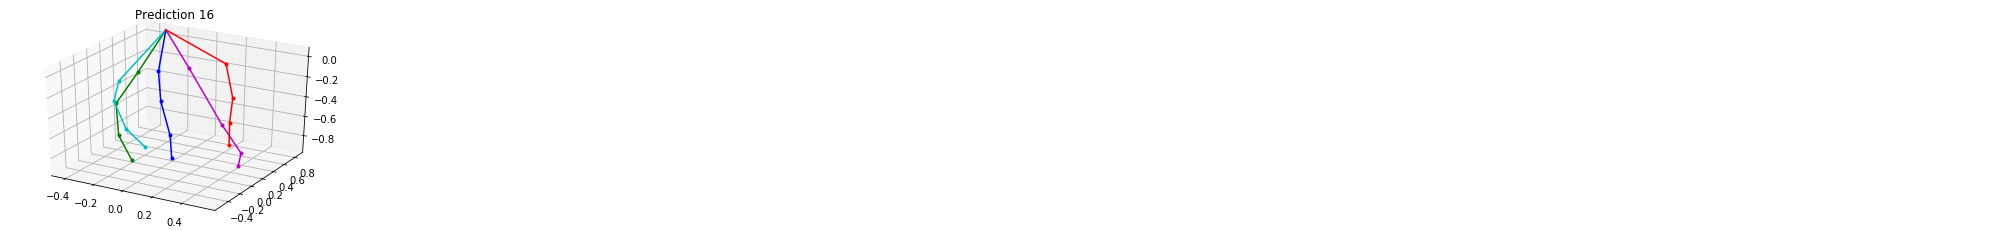

In [54]:
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)

vector = output['vector_3d'].detach().cpu()
sample['image'] = sample['image'].cpu()
visualize_3d(sample['image'], vector)

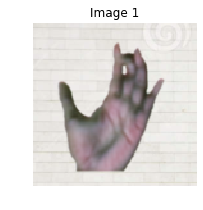

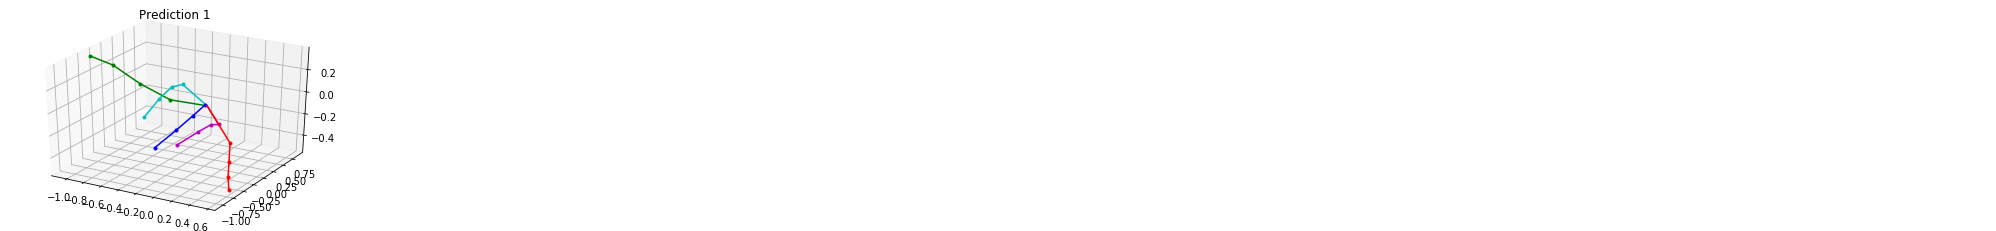

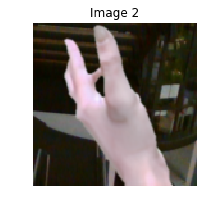

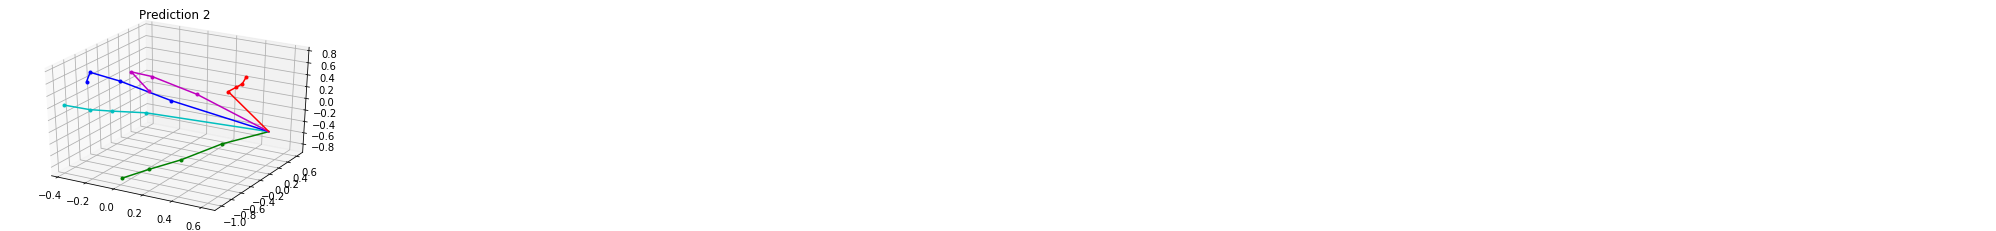

In [34]:
vector = sample['vector_3d']
sample['image'] = sample['image'].cpu()
visualize_3d(sample['image'][:2,:,:,:], vector[:2,:])

In [2]:
experiment = 'e012'

config_file = 'experiment/' + experiment + '/config.yaml'
with open(config_file, 'r') as f:
        config = yaml.load(f)

config['batch_size'] = 16
cuda = int(config['cuda'])
#config['dataset'] = 'ganerated'
dataloader = get_dataloader(config, 'val')
model = get_model(config)
#model.load_state_dict(torch.load(config['weights'])['model'])

Images in GANerated dataset: 5000


In [3]:
sample = next(iter(dataloader))
sample['image'] = sample['image'].cuda(cuda)
output = model(sample)

/home/ochernytska/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [8]:
output['heatmaps'][0,0,:,:]

tensor([[0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        ...,
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001,  ..., 0.0001, 0.0001, 0.0001]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [4]:
with open('__local__config.yaml', 'r') as f:
    local_config = yaml.load(f)
path_to_data = local_config['data_path']
root_dir = path_to_data + 'stereohandtracking/'
root_dir

'/mnt/data/handpose/stereohandtracking/'

In [45]:
def get_splitted_image_names(root_dir): 
    
    image_names = np.array([])
    folders = os.listdir(root_dir + 'images/')
    for folder in folders:
        files = [x for x in os.listdir(root_dir + '/images/' + folder) if x.find('SK_color')>-1]
        files = [root_dir + 'images/' + folder + '/' + x for x in files]
        image_names = np.hstack((image_names,files))
    
    image_names = np.sort(image_names)
    val = image_names[:3000]
    train = image_names[3000:]
    
    return {'train': train, 'val': val}
    

In [42]:
files = get_splitted_image_names(root_dir)

['/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_0.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_10.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_100.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1000.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1001.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1002.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1003.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1004.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Counting/SK_color_1005.png']


In [44]:
files = get_splitted_image_names(root_dir)

['/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_990.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_991.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_992.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_993.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_994.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_995.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_996.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_997.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_998.png'
 '/mnt/data/handpose/stereohandtracking/images/B1Random/SK_color_999.png']


In [46]:
files = get_splitted_image_names(root_dir)

['/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_0.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_10.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_100.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1000.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1001.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1002.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1003.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1004.png'
 '/mnt/data/handpose/stereohandtracking/images/B2Counting/SK_color_1005.png']


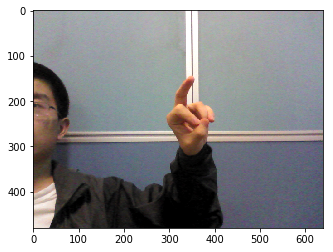

In [40]:
img = Image.open('/mnt/data/handpose/stereohandtracking/images/B3Random/SK_color_549.png')
plt.imshow(img)